<a href="https://colab.research.google.com/github/jamesBaker361/colab/blob/master/FashionGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://medium.com/ai-society/gans-from-scratch-1-a-deep-introduction-with-code-in-pytorch-and-tensorflow-cb03cdcdba0f

In [1]:
!pip install torchvision tensorboardx jupyter matplotlib nump

  ERROR: Could not find a version that satisfies the requirement nump (from versions: none)
ERROR: No matching distribution found for nump


In [2]:
!pip install numpy


In [0]:
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

In [0]:
def mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize([0.5], [0.5])
        ])
    out_dir = './dataset'
    return datasets.FashionMNIST(root=out_dir, train=True, transform=compose, download=True)
# Load data
data = mnist_data()
# Create loader with data, so that we can iterate over it
data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)
# Num batches
num_batches = len(data_loader)

In [0]:
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 784
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
discriminator = DiscriminatorNet()

In [0]:
def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

In [0]:
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 784
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
generator = GeneratorNet()

In [0]:
def noise(size):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = Variable(torch.randn(size, 100))
    return n

In [0]:
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

In [0]:
loss = nn.BCELoss()

In [0]:
def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    return data

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    return data

In [0]:
def train_discriminator(optimizer, real_data, fake_data):
    N = real_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, ones_target(N) )
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, zeros_target(N))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error and predictions for real and fake inputs
    return error_real + error_fake, prediction_real, prediction_fake

In [0]:
def train_generator(optimizer, fake_data):
    N = fake_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, ones_target(N))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

In [0]:
num_test_samples = 16
test_noise = noise(num_test_samples)

In [15]:
test_noise

tensor([[-0.6721, -0.5601, -1.1511,  ..., -1.1605, -1.5691, -0.2699],
        [ 0.9706, -1.1461,  0.2778,  ...,  0.3002, -0.0304, -1.2775],
        [ 0.0549, -1.3031,  0.2501,  ...,  0.9595,  1.5636, -0.7196],
        ...,
        [-0.6532, -1.0199,  0.4532,  ..., -0.4307,  0.3432, -0.6193],
        [-0.3134, -0.8342,  1.0482,  ..., -0.1887,  2.3084, -1.6302],
        [-2.4165,  0.8308, -1.8723,  ...,  0.7291,  0.0521, -0.3384]])

In [16]:
!pip install tensorboardX
import os
import numpy as np
import errno
import torchvision.utils as vutils
from tensorboardX import SummaryWriter
from IPython import display
from matplotlib import pyplot as plt
import torch

'''
    TensorBoard Data will be stored in './runs' path
'''


class Logger:

    def __init__(self, model_name, data_name):
        self.model_name = model_name
        self.data_name = data_name

        self.comment = '{}_{}'.format(model_name, data_name)
        self.data_subdir = '{}/{}'.format(model_name, data_name)

        # TensorBoard
        self.writer = SummaryWriter(comment=self.comment)

    def log(self, d_error, g_error, epoch, n_batch, num_batches):

        # var_class = torch.autograd.variable.Variable
        if isinstance(d_error, torch.autograd.Variable):
            d_error = d_error.data.cpu().numpy()
        if isinstance(g_error, torch.autograd.Variable):
            g_error = g_error.data.cpu().numpy()

        step = Logger._step(epoch, n_batch, num_batches)
        self.writer.add_scalar(
            '{}/D_error'.format(self.comment), d_error, step)
        self.writer.add_scalar(
            '{}/G_error'.format(self.comment), g_error, step)

    def log_images(self, images, num_images, epoch, n_batch, num_batches, format='NCHW', normalize=True):
        '''
        input images are expected in format (NCHW)
        '''
        if type(images) == np.ndarray:
            images = torch.from_numpy(images)
        
        if format=='NHWC':
            images = images.transpose(1,3)
        

        step = Logger._step(epoch, n_batch, num_batches)
        img_name = '{}/images{}'.format(self.comment, '')

        # Make horizontal grid from image tensor
        horizontal_grid = vutils.make_grid(
            images, normalize=normalize, scale_each=True)
        # Make vertical grid from image tensor
        nrows = int(np.sqrt(num_images))
        grid = vutils.make_grid(
            images, nrow=nrows, normalize=True, scale_each=True)

        # Add horizontal images to tensorboard
        self.writer.add_image(img_name, horizontal_grid, step)

        # Save plots
        self.save_torch_images(horizontal_grid, grid, epoch, n_batch)

    def save_torch_images(self, horizontal_grid, grid, epoch, n_batch, plot_horizontal=True):
        out_dir = './data/images/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)

        # Plot and save horizontal
        fig = plt.figure(figsize=(16, 16))
        plt.imshow(np.moveaxis(horizontal_grid.numpy(), 0, -1))
        plt.axis('off')
        if plot_horizontal:
            display.display(plt.gcf())
        self._save_images(fig, epoch, n_batch, 'hori')
        plt.close()

        # Save squared
        fig = plt.figure()
        plt.imshow(np.moveaxis(grid.numpy(), 0, -1))
        plt.axis('off')
        self._save_images(fig, epoch, n_batch)
        plt.close()

    def _save_images(self, fig, epoch, n_batch, comment=''):
        out_dir = './data/images/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)
        fig.savefig('{}/{}_epoch_{}_batch_{}.png'.format(out_dir,
                                                         comment, epoch, n_batch))

    def display_status(self, epoch, num_epochs, n_batch, num_batches, d_error, g_error, d_pred_real, d_pred_fake):
        
        # var_class = torch.autograd.variable.Variable
        if isinstance(d_error, torch.autograd.Variable):
            d_error = d_error.data.cpu().numpy()
        if isinstance(g_error, torch.autograd.Variable):
            g_error = g_error.data.cpu().numpy()
        if isinstance(d_pred_real, torch.autograd.Variable):
            d_pred_real = d_pred_real.data
        if isinstance(d_pred_fake, torch.autograd.Variable):
            d_pred_fake = d_pred_fake.data
        
        
        print('Epoch: [{}/{}], Batch Num: [{}/{}]'.format(
            epoch,num_epochs, n_batch, num_batches)
             )
        print('Discriminator Loss: {:.4f}, Generator Loss: {:.4f}'.format(d_error, g_error))
        print('D(x): {:.4f}, D(G(z)): {:.4f}'.format(d_pred_real.mean(), d_pred_fake.mean()))

    def save_models(self, generator, discriminator, epoch):
        out_dir = './data/models/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)
        torch.save(generator.state_dict(),
                   '{}/G_epoch_{}'.format(out_dir, epoch))
        torch.save(discriminator.state_dict(),
                   '{}/D_epoch_{}'.format(out_dir, epoch))

    def close(self):
        self.writer.close()

    # Private Functionality

    @staticmethod
    def _step(epoch, n_batch, num_batches):
        return epoch * num_batches + n_batch

    @staticmethod
    def _make_dir(directory):
        try:
            os.makedirs(directory)
        except OSError as e:
            if e.errno != errno.EEXIST:
                raise

In [0]:

num_batches = len(data_loader)
logger = Logger(model_name='VGAN', data_name='MNIST')

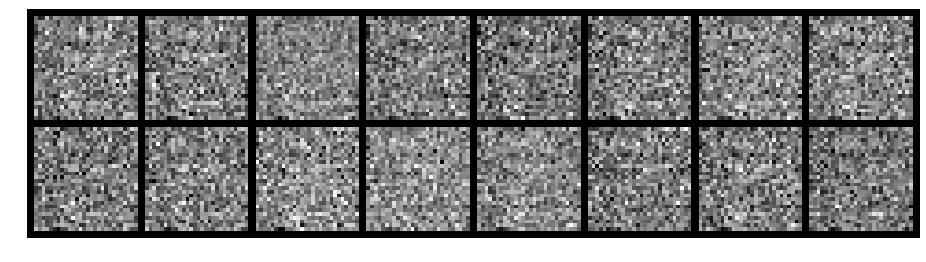

Epoch: [0/200], Batch Num: [0/600]
Discriminator Loss: 1.3648, Generator Loss: 0.6980
D(x): 0.5078, D(G(z)): 0.4968


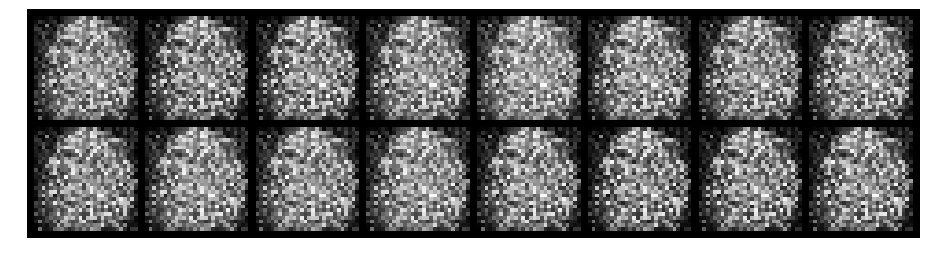

Epoch: [0/200], Batch Num: [100/600]
Discriminator Loss: 2.6052, Generator Loss: 1.2821
D(x): 0.5805, D(G(z)): 0.7838


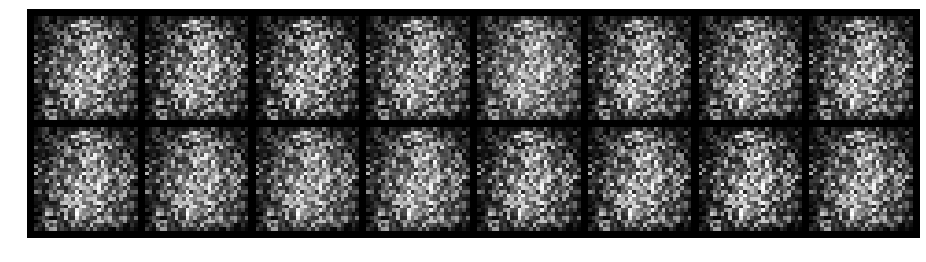

Epoch: [0/200], Batch Num: [200/600]
Discriminator Loss: 0.2335, Generator Loss: 2.5861
D(x): 0.9489, D(G(z)): 0.1570


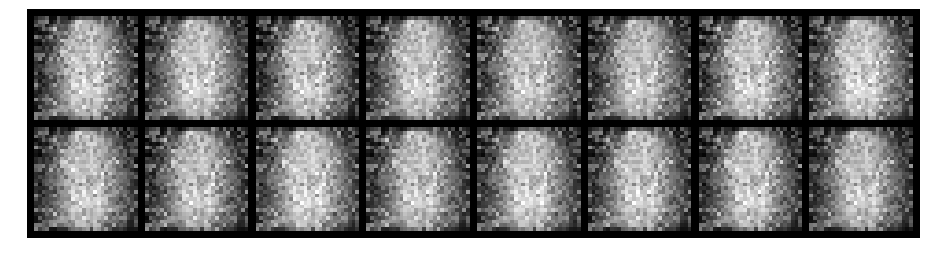

Epoch: [0/200], Batch Num: [300/600]
Discriminator Loss: 0.3722, Generator Loss: 2.4605
D(x): 0.9067, D(G(z)): 0.1914


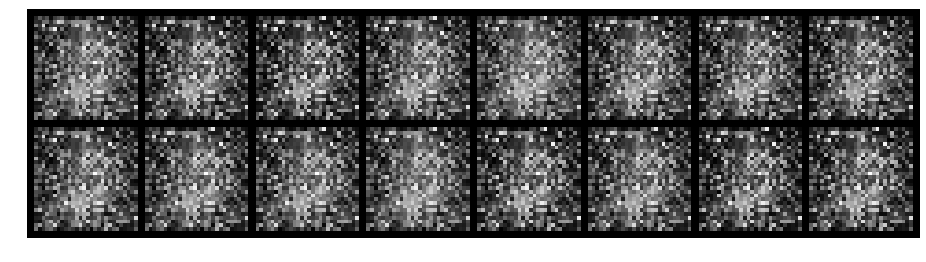

Epoch: [0/200], Batch Num: [400/600]
Discriminator Loss: 0.5480, Generator Loss: 5.8532
D(x): 0.8389, D(G(z)): 0.1977


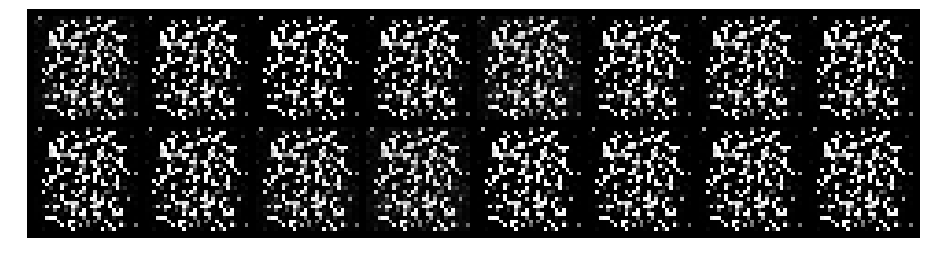

Epoch: [0/200], Batch Num: [500/600]
Discriminator Loss: 0.1684, Generator Loss: 7.3586
D(x): 0.9508, D(G(z)): 0.0873


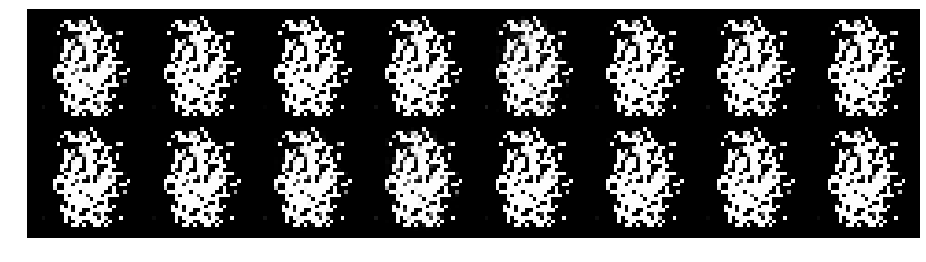

Epoch: [1/200], Batch Num: [0/600]
Discriminator Loss: 0.0123, Generator Loss: 11.5359
D(x): 0.9904, D(G(z)): 0.0013


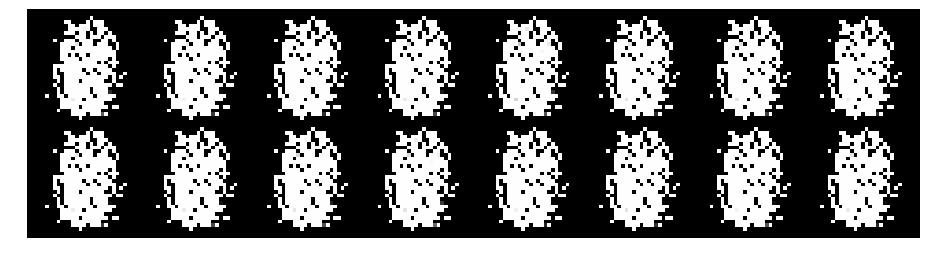

Epoch: [1/200], Batch Num: [100/600]
Discriminator Loss: 0.0050, Generator Loss: 10.1456
D(x): 0.9955, D(G(z)): 0.0003


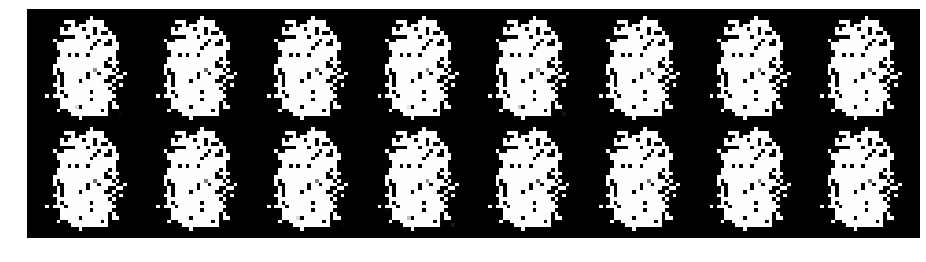

Epoch: [1/200], Batch Num: [200/600]
Discriminator Loss: 0.0038, Generator Loss: 9.3079
D(x): 0.9976, D(G(z)): 0.0013


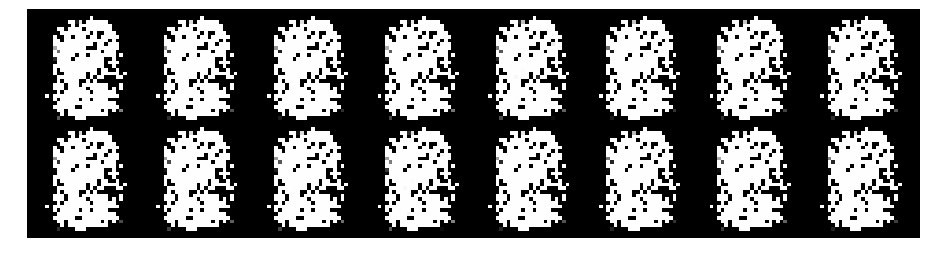

Epoch: [1/200], Batch Num: [300/600]
Discriminator Loss: 0.0031, Generator Loss: 8.6823
D(x): 0.9994, D(G(z)): 0.0025


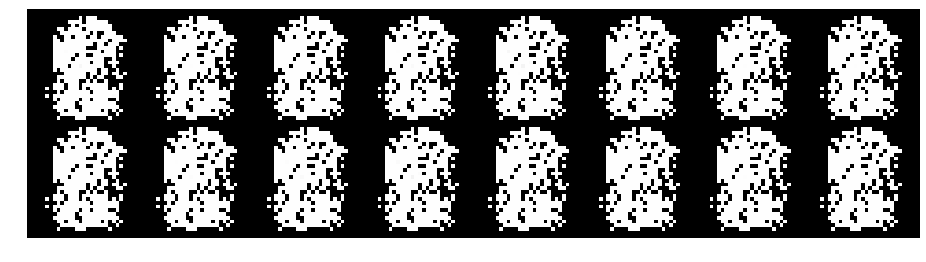

Epoch: [1/200], Batch Num: [400/600]
Discriminator Loss: 0.0008, Generator Loss: 11.4986
D(x): 0.9997, D(G(z)): 0.0005


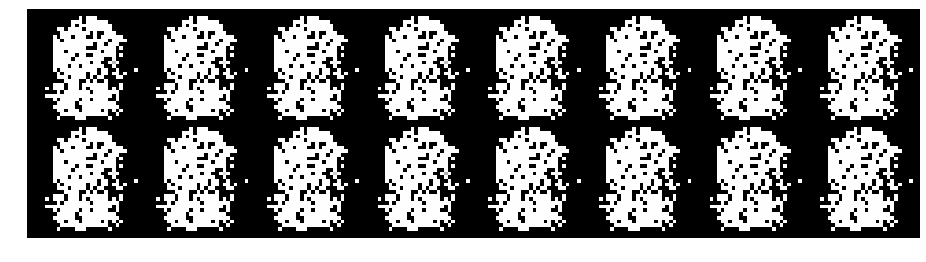

Epoch: [1/200], Batch Num: [500/600]
Discriminator Loss: 0.0037, Generator Loss: 12.0722
D(x): 0.9969, D(G(z)): 0.0001


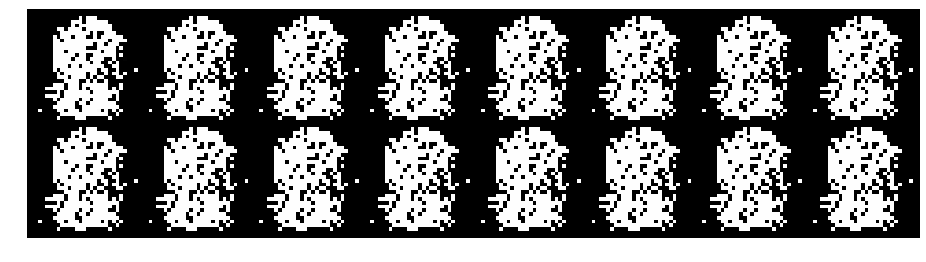

Epoch: [2/200], Batch Num: [0/600]
Discriminator Loss: 0.0002, Generator Loss: 12.2638
D(x): 0.9998, D(G(z)): 0.0000


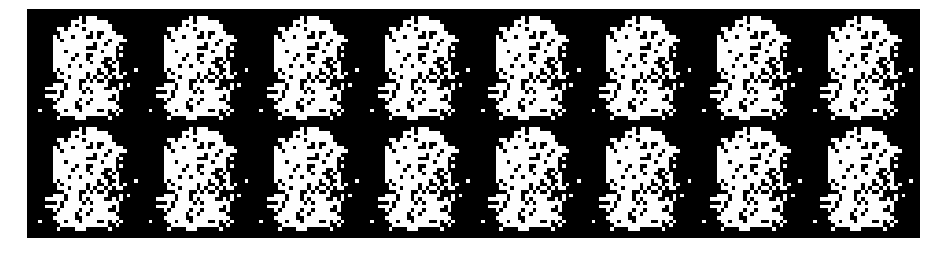

Epoch: [2/200], Batch Num: [100/600]
Discriminator Loss: 0.0002, Generator Loss: 13.1243
D(x): 0.9999, D(G(z)): 0.0000


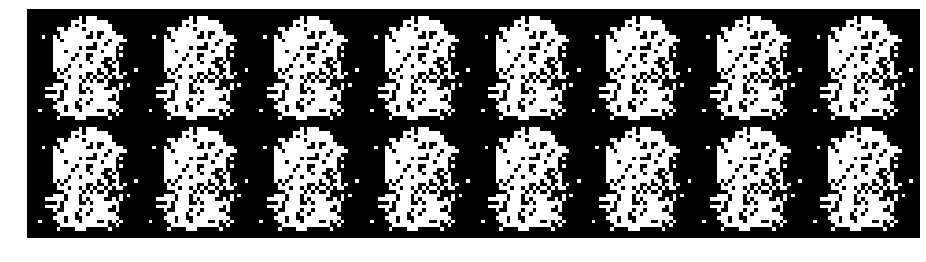

Epoch: [2/200], Batch Num: [200/600]
Discriminator Loss: 0.0001, Generator Loss: 13.3231
D(x): 0.9999, D(G(z)): 0.0000


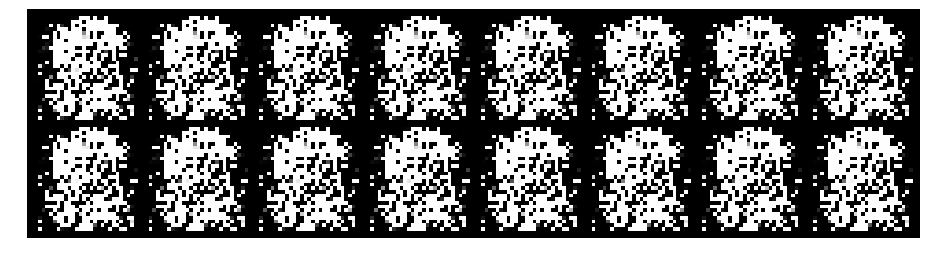

Epoch: [2/200], Batch Num: [300/600]
Discriminator Loss: 0.0006, Generator Loss: 12.3636
D(x): 0.9995, D(G(z)): 0.0001


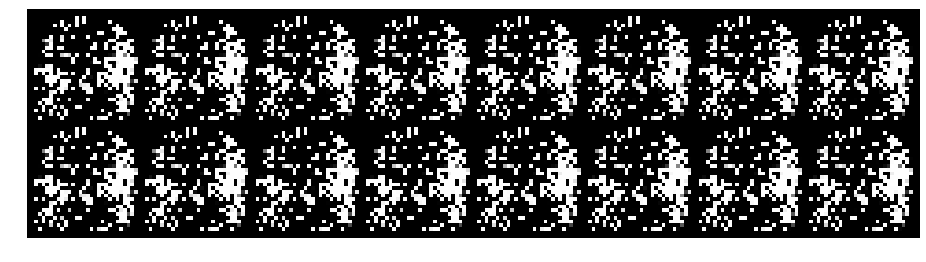

Epoch: [2/200], Batch Num: [400/600]
Discriminator Loss: 0.0004, Generator Loss: 10.7074
D(x): 1.0000, D(G(z)): 0.0004


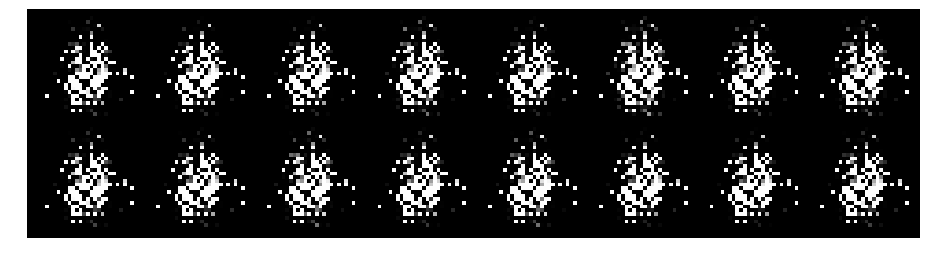

Epoch: [2/200], Batch Num: [500/600]
Discriminator Loss: 0.0921, Generator Loss: 15.5015
D(x): 0.9531, D(G(z)): 0.0000


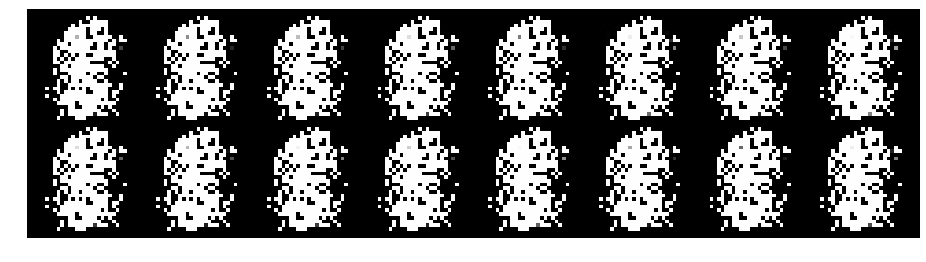

Epoch: [3/200], Batch Num: [0/600]
Discriminator Loss: 0.0001, Generator Loss: 21.1685
D(x): 0.9999, D(G(z)): 0.0000


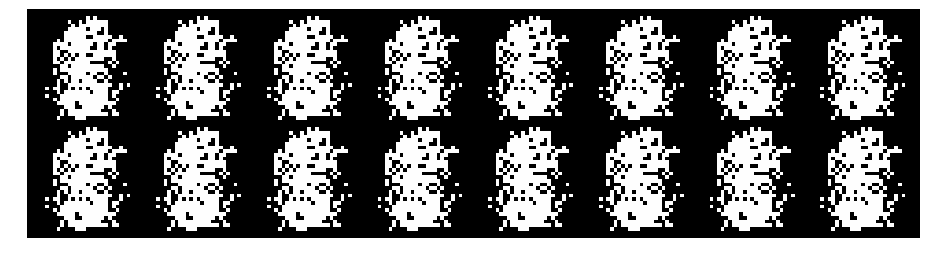

Epoch: [3/200], Batch Num: [100/600]
Discriminator Loss: 0.0001, Generator Loss: 16.9363
D(x): 0.9999, D(G(z)): 0.0000


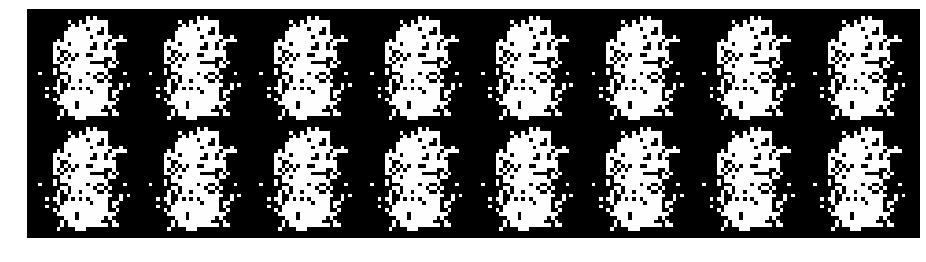

Epoch: [3/200], Batch Num: [200/600]
Discriminator Loss: 0.0001, Generator Loss: 15.0166
D(x): 0.9999, D(G(z)): 0.0000


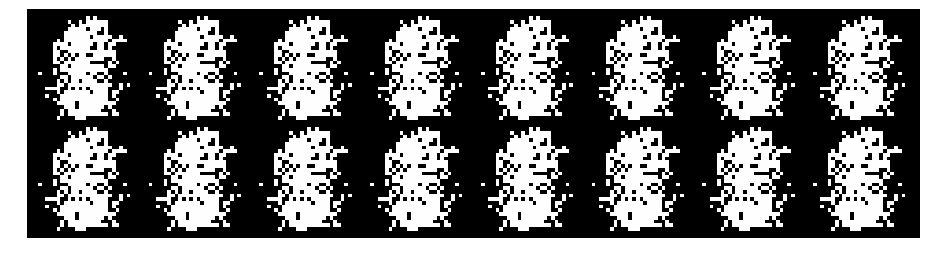

Epoch: [3/200], Batch Num: [300/600]
Discriminator Loss: 0.0000, Generator Loss: 15.6281
D(x): 1.0000, D(G(z)): 0.0000


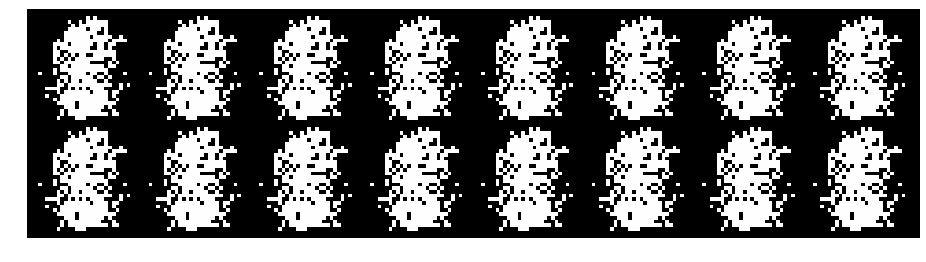

Epoch: [3/200], Batch Num: [400/600]
Discriminator Loss: 0.0000, Generator Loss: 15.7279
D(x): 1.0000, D(G(z)): 0.0000


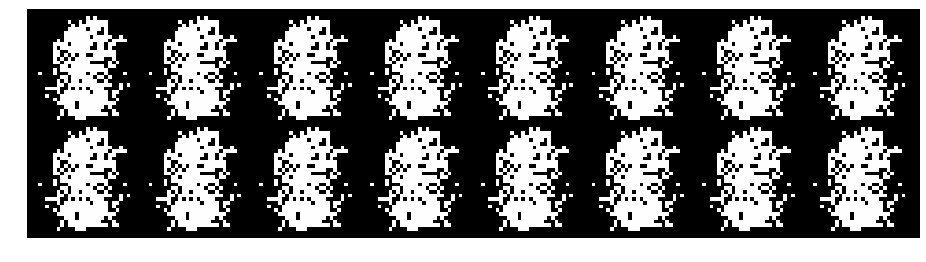

Epoch: [3/200], Batch Num: [500/600]
Discriminator Loss: 0.0001, Generator Loss: 15.8191
D(x): 0.9999, D(G(z)): 0.0000


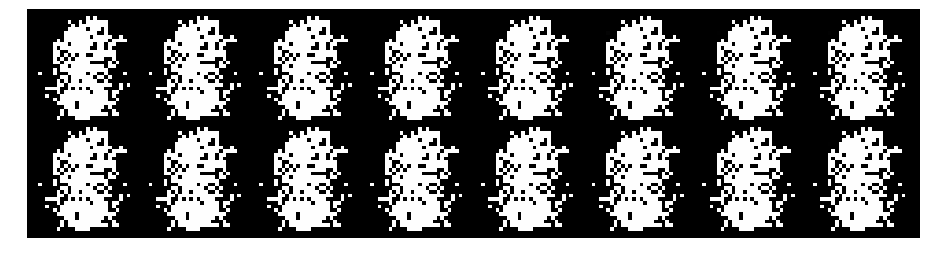

Epoch: [4/200], Batch Num: [0/600]
Discriminator Loss: 0.0000, Generator Loss: 14.6788
D(x): 1.0000, D(G(z)): 0.0000


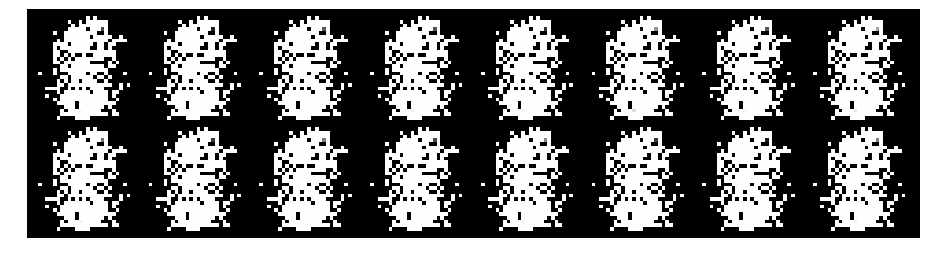

Epoch: [4/200], Batch Num: [100/600]
Discriminator Loss: 0.0000, Generator Loss: 15.4123
D(x): 1.0000, D(G(z)): 0.0000


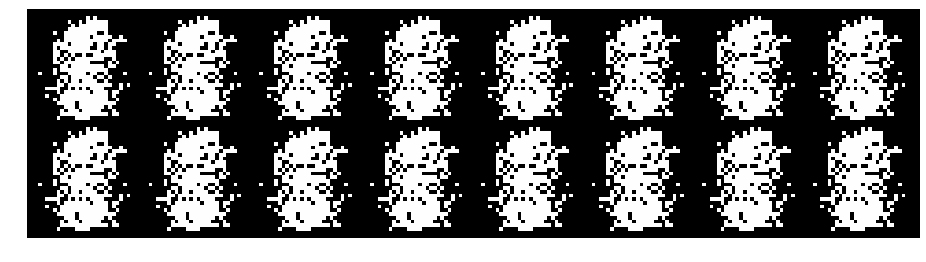

Epoch: [4/200], Batch Num: [200/600]
Discriminator Loss: 0.0000, Generator Loss: 16.0766
D(x): 1.0000, D(G(z)): 0.0000


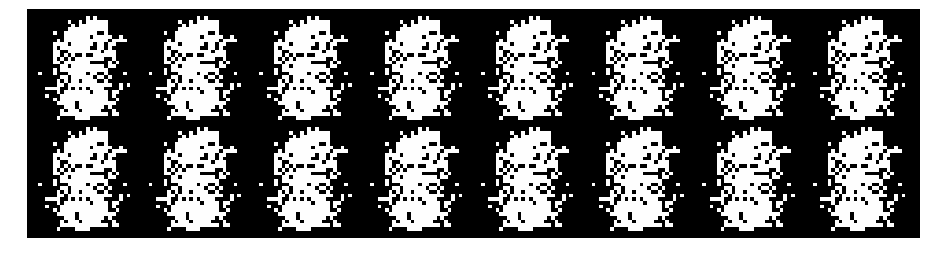

Epoch: [4/200], Batch Num: [300/600]
Discriminator Loss: 0.0000, Generator Loss: 17.0789
D(x): 1.0000, D(G(z)): 0.0000


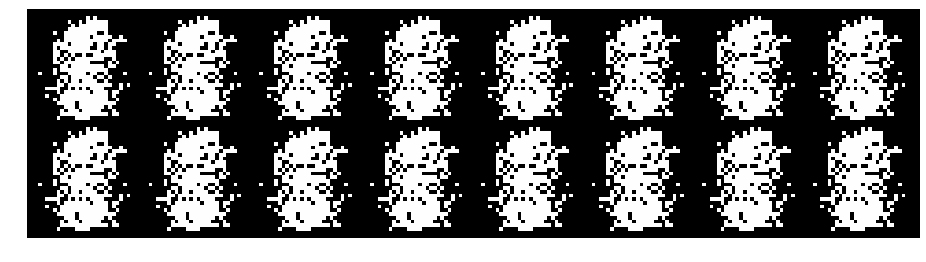

Epoch: [4/200], Batch Num: [400/600]
Discriminator Loss: 0.0000, Generator Loss: 17.2725
D(x): 1.0000, D(G(z)): 0.0000


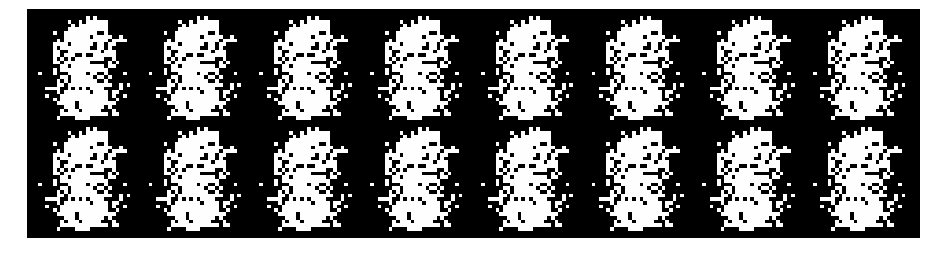

Epoch: [4/200], Batch Num: [500/600]
Discriminator Loss: 0.0000, Generator Loss: 15.9773
D(x): 1.0000, D(G(z)): 0.0000


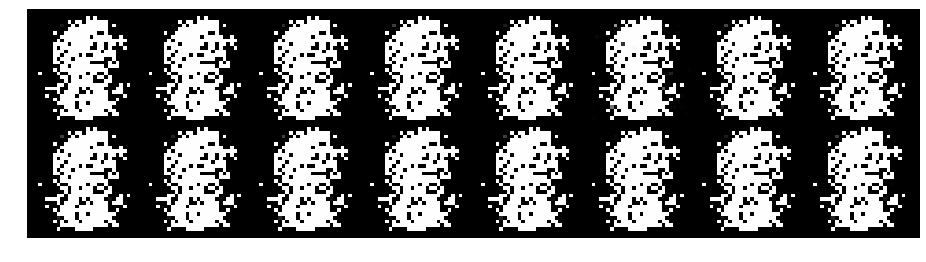

Epoch: [5/200], Batch Num: [0/600]
Discriminator Loss: 0.0001, Generator Loss: 12.7254
D(x): 1.0000, D(G(z)): 0.0000


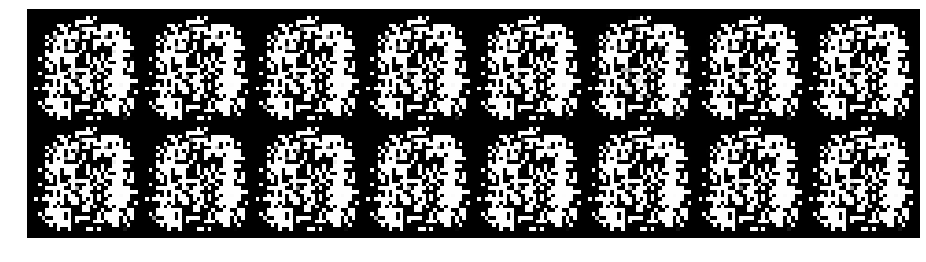

Epoch: [5/200], Batch Num: [100/600]
Discriminator Loss: 0.0218, Generator Loss: 11.1273
D(x): 0.9901, D(G(z)): 0.0007


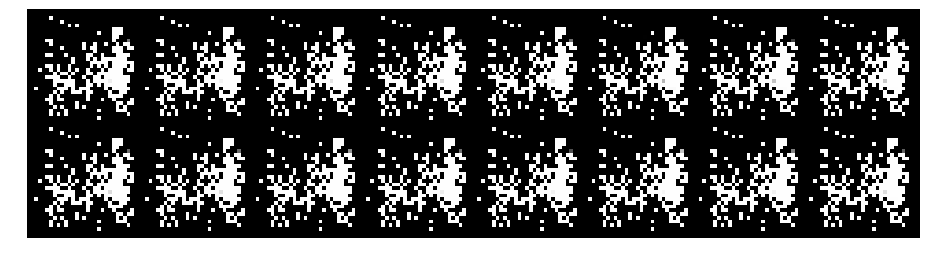

Epoch: [5/200], Batch Num: [200/600]
Discriminator Loss: 0.0004, Generator Loss: 11.8616
D(x): 1.0000, D(G(z)): 0.0004


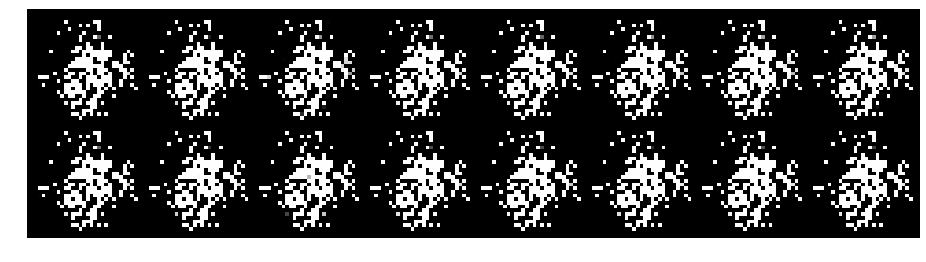

Epoch: [5/200], Batch Num: [300/600]
Discriminator Loss: 0.0065, Generator Loss: 10.1980
D(x): 0.9986, D(G(z)): 0.0050


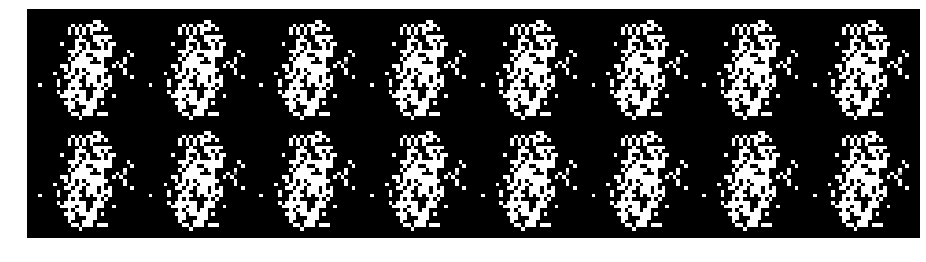

Epoch: [5/200], Batch Num: [400/600]
Discriminator Loss: 0.0000, Generator Loss: 16.7697
D(x): 1.0000, D(G(z)): 0.0000


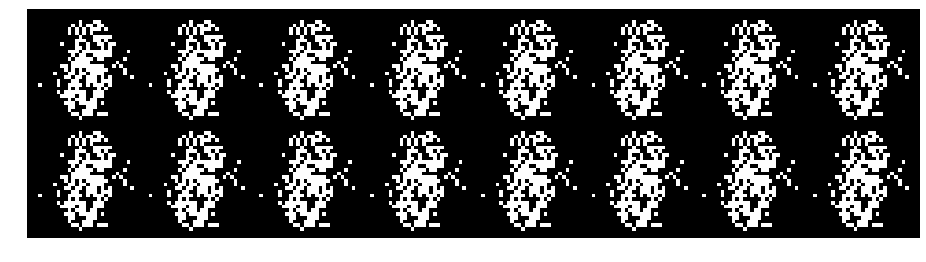

Epoch: [5/200], Batch Num: [500/600]
Discriminator Loss: 0.0000, Generator Loss: 16.6176
D(x): 1.0000, D(G(z)): 0.0000


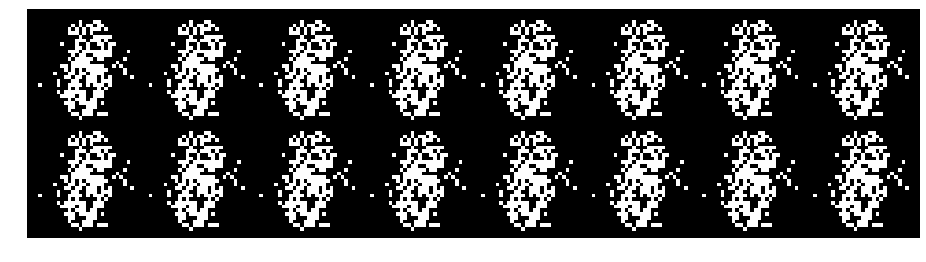

Epoch: [6/200], Batch Num: [0/600]
Discriminator Loss: 0.0000, Generator Loss: 16.7992
D(x): 1.0000, D(G(z)): 0.0000


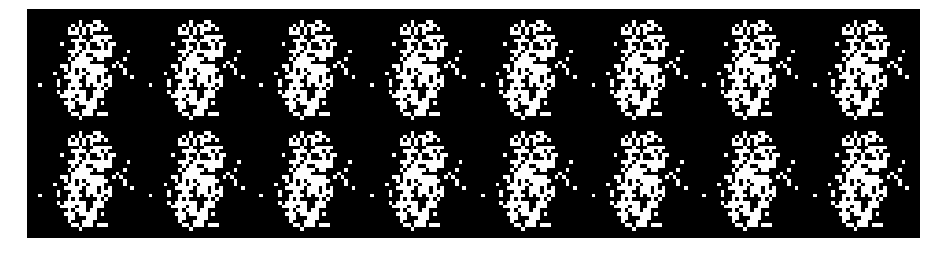

Epoch: [6/200], Batch Num: [100/600]
Discriminator Loss: 0.0000, Generator Loss: 16.7450
D(x): 1.0000, D(G(z)): 0.0000


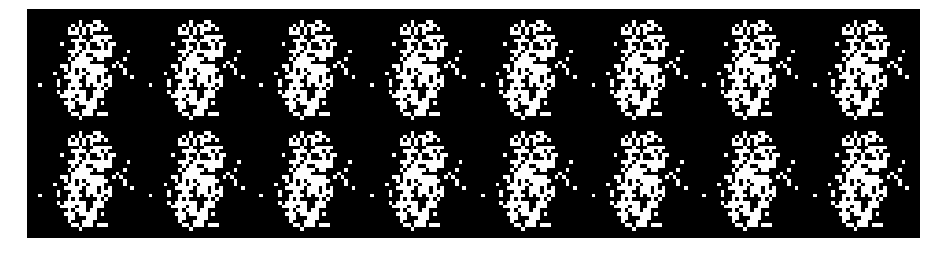

Epoch: [6/200], Batch Num: [200/600]
Discriminator Loss: 0.0000, Generator Loss: 17.4658
D(x): 1.0000, D(G(z)): 0.0000


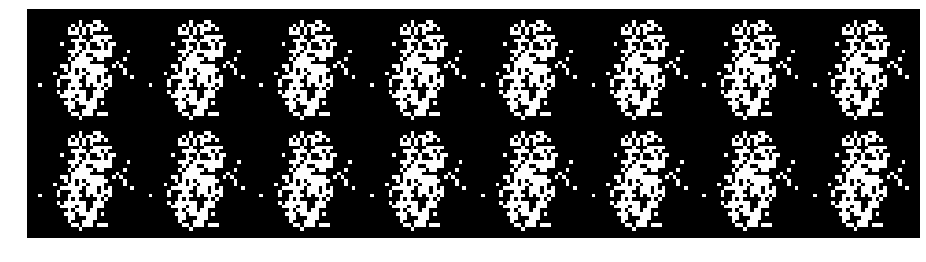

Epoch: [6/200], Batch Num: [300/600]
Discriminator Loss: 0.0000, Generator Loss: 16.9255
D(x): 1.0000, D(G(z)): 0.0000


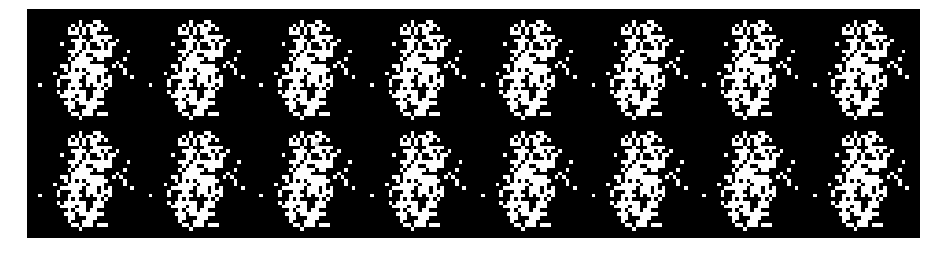

Epoch: [6/200], Batch Num: [400/600]
Discriminator Loss: 0.0000, Generator Loss: 16.2093
D(x): 1.0000, D(G(z)): 0.0000


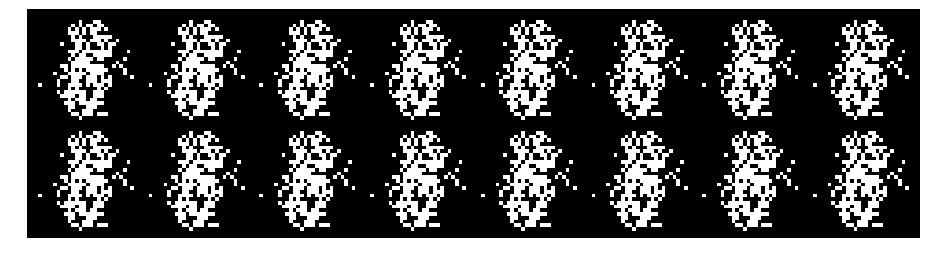

Epoch: [6/200], Batch Num: [500/600]
Discriminator Loss: 0.0000, Generator Loss: 16.4391
D(x): 1.0000, D(G(z)): 0.0000


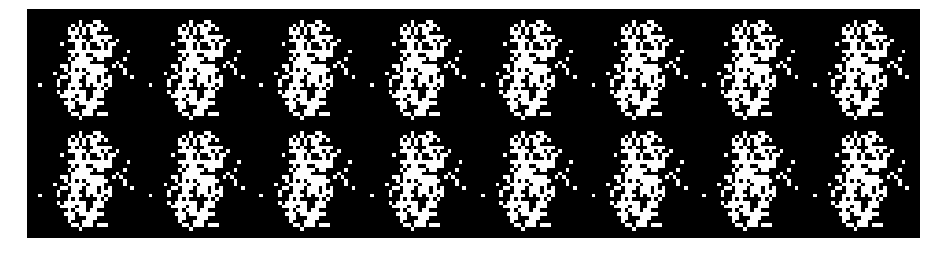

Epoch: [7/200], Batch Num: [0/600]
Discriminator Loss: 0.0000, Generator Loss: 17.3593
D(x): 1.0000, D(G(z)): 0.0000


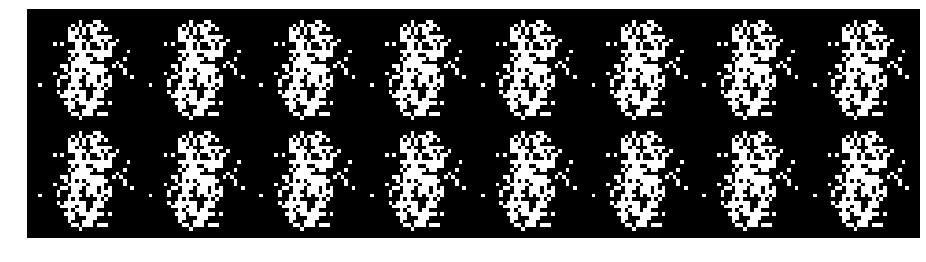

Epoch: [7/200], Batch Num: [100/600]
Discriminator Loss: 0.0000, Generator Loss: 16.6955
D(x): 1.0000, D(G(z)): 0.0000


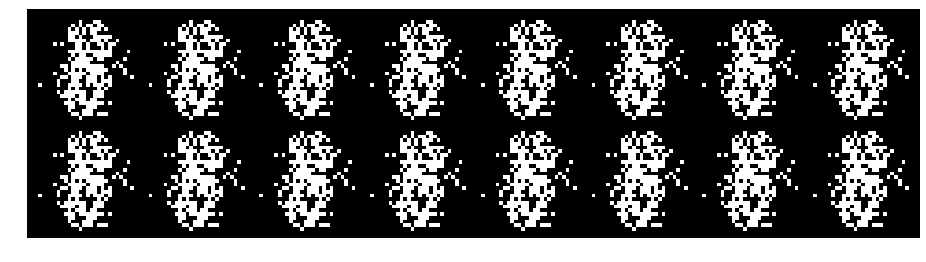

Epoch: [7/200], Batch Num: [200/600]
Discriminator Loss: 0.0000, Generator Loss: 17.8312
D(x): 1.0000, D(G(z)): 0.0000


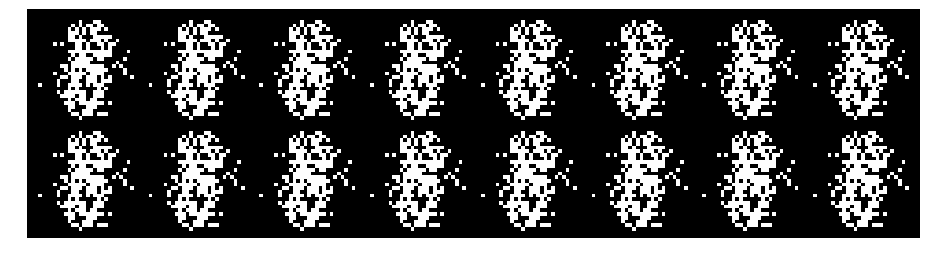

Epoch: [7/200], Batch Num: [300/600]
Discriminator Loss: 0.0000, Generator Loss: 17.4662
D(x): 1.0000, D(G(z)): 0.0000


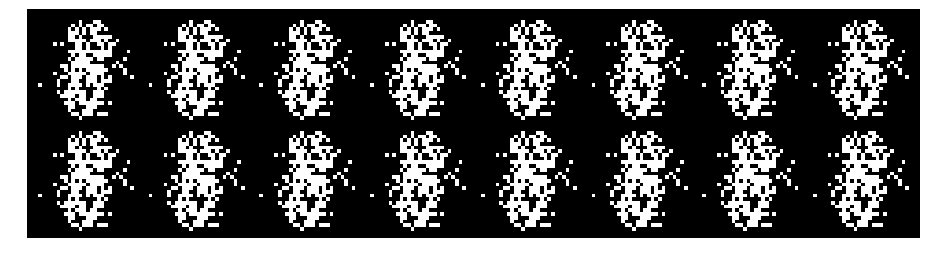

Epoch: [7/200], Batch Num: [400/600]
Discriminator Loss: 0.0000, Generator Loss: 17.7335
D(x): 1.0000, D(G(z)): 0.0000


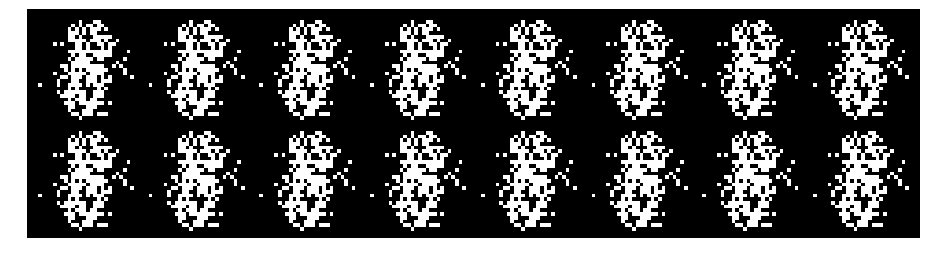

Epoch: [7/200], Batch Num: [500/600]
Discriminator Loss: 0.0000, Generator Loss: 18.2275
D(x): 1.0000, D(G(z)): 0.0000


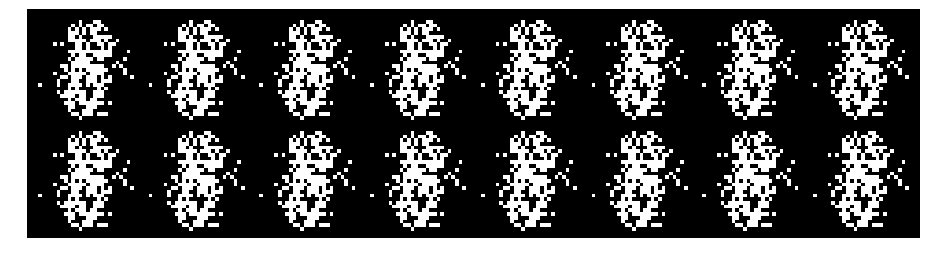

Epoch: [8/200], Batch Num: [0/600]
Discriminator Loss: 0.0000, Generator Loss: 18.9078
D(x): 1.0000, D(G(z)): 0.0000


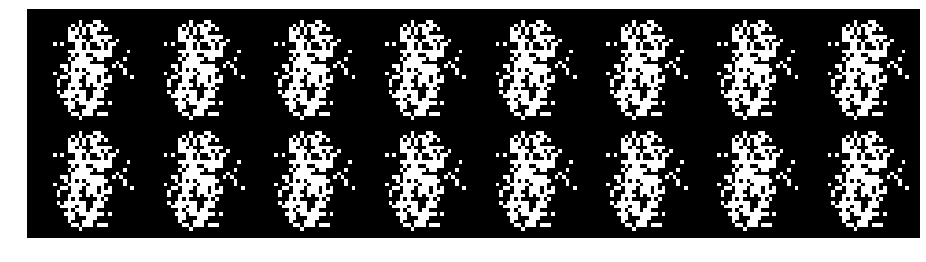

Epoch: [8/200], Batch Num: [100/600]
Discriminator Loss: 0.0000, Generator Loss: 18.6056
D(x): 1.0000, D(G(z)): 0.0000


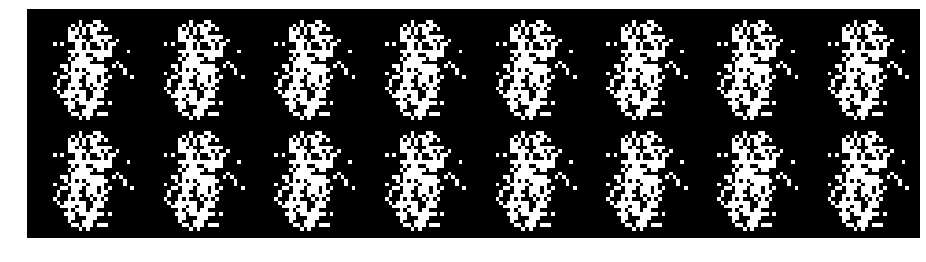

Epoch: [8/200], Batch Num: [200/600]
Discriminator Loss: 0.0000, Generator Loss: 18.1174
D(x): 1.0000, D(G(z)): 0.0000


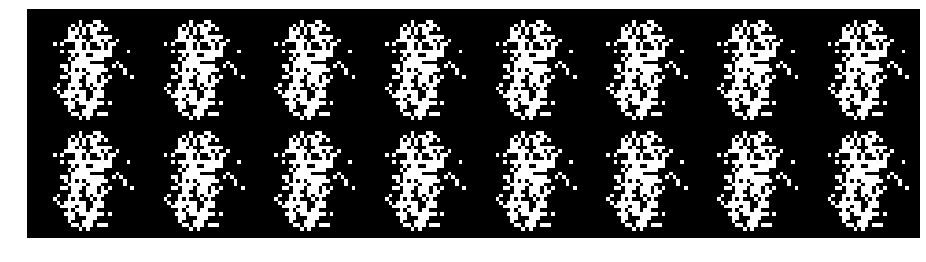

Epoch: [8/200], Batch Num: [300/600]
Discriminator Loss: 0.0000, Generator Loss: 15.2917
D(x): 1.0000, D(G(z)): 0.0000


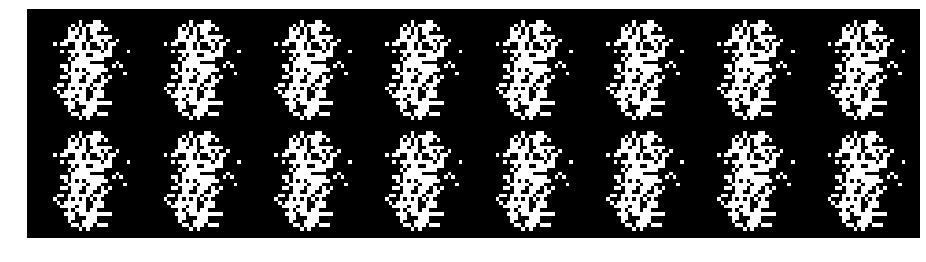

Epoch: [8/200], Batch Num: [400/600]
Discriminator Loss: 0.0000, Generator Loss: 16.7545
D(x): 1.0000, D(G(z)): 0.0000


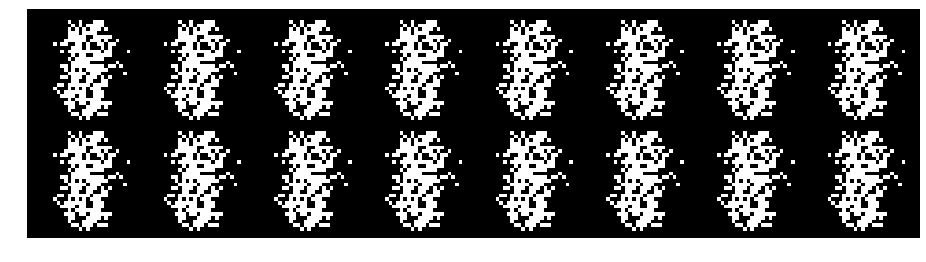

Epoch: [8/200], Batch Num: [500/600]
Discriminator Loss: 0.0000, Generator Loss: 16.4215
D(x): 1.0000, D(G(z)): 0.0000


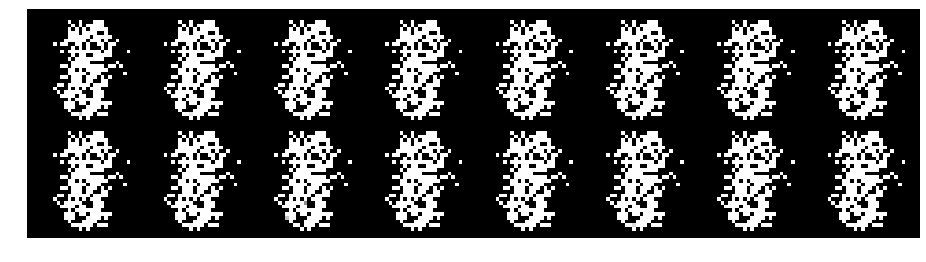

Epoch: [9/200], Batch Num: [0/600]
Discriminator Loss: 0.0000, Generator Loss: 22.2424
D(x): 1.0000, D(G(z)): 0.0000


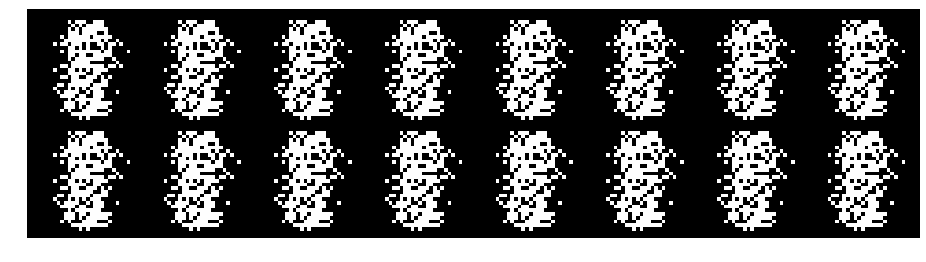

Epoch: [9/200], Batch Num: [100/600]
Discriminator Loss: 0.0000, Generator Loss: 18.0399
D(x): 1.0000, D(G(z)): 0.0000


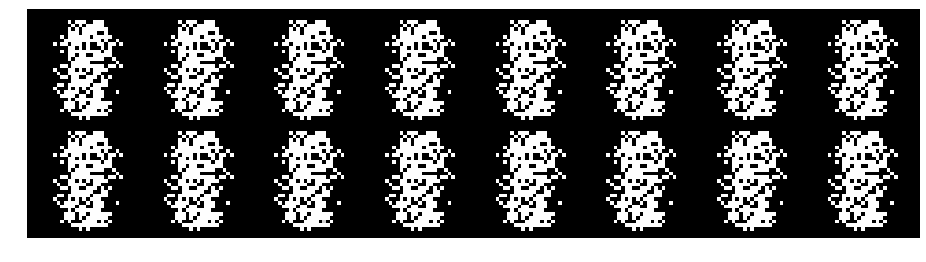

Epoch: [9/200], Batch Num: [200/600]
Discriminator Loss: 0.0000, Generator Loss: 19.7236
D(x): 1.0000, D(G(z)): 0.0000


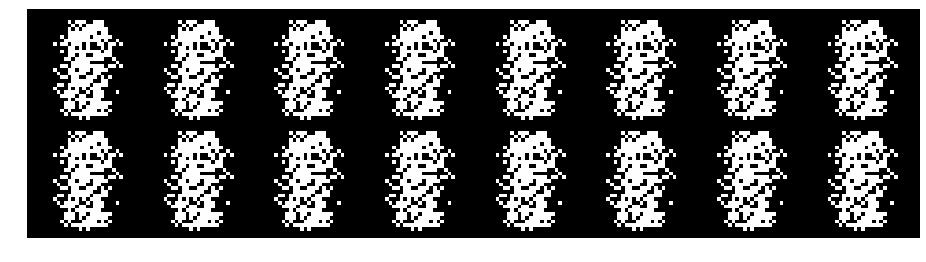

Epoch: [9/200], Batch Num: [300/600]
Discriminator Loss: 0.0000, Generator Loss: 21.7585
D(x): 1.0000, D(G(z)): 0.0000


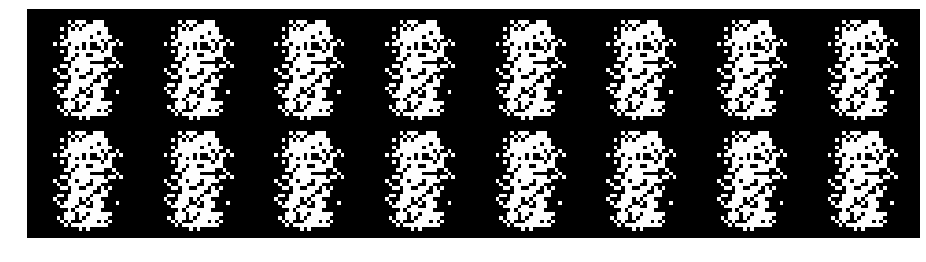

Epoch: [9/200], Batch Num: [400/600]
Discriminator Loss: 0.0000, Generator Loss: 19.7904
D(x): 1.0000, D(G(z)): 0.0000


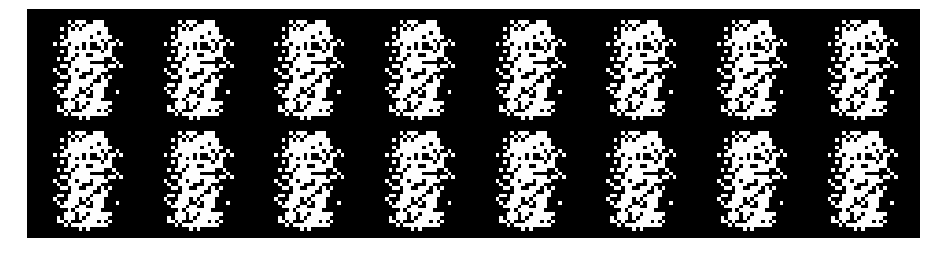

Epoch: [9/200], Batch Num: [500/600]
Discriminator Loss: 0.0000, Generator Loss: 19.8681
D(x): 1.0000, D(G(z)): 0.0000


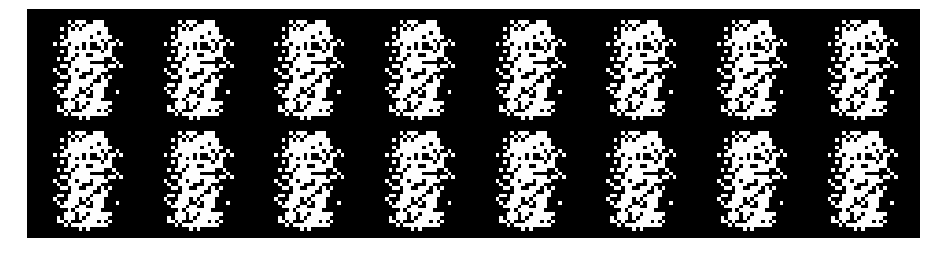

Epoch: [10/200], Batch Num: [0/600]
Discriminator Loss: 0.0000, Generator Loss: 19.7799
D(x): 1.0000, D(G(z)): 0.0000


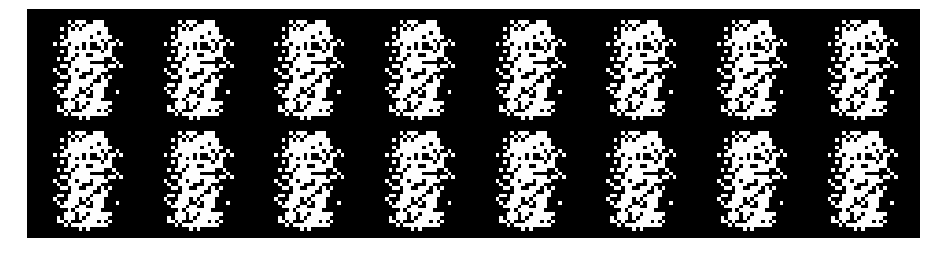

Epoch: [10/200], Batch Num: [100/600]
Discriminator Loss: 0.0000, Generator Loss: 20.4663
D(x): 1.0000, D(G(z)): 0.0000


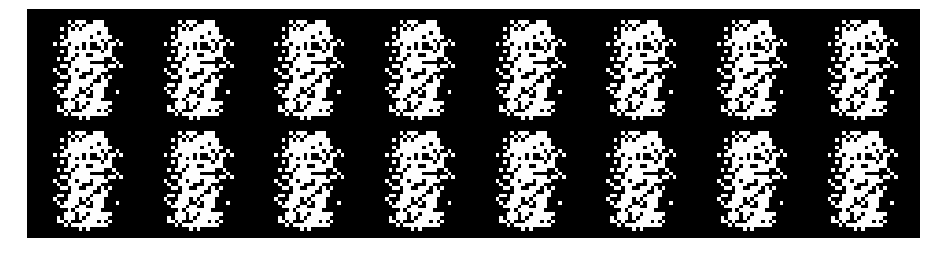

Epoch: [10/200], Batch Num: [200/600]
Discriminator Loss: 0.0000, Generator Loss: 19.4580
D(x): 1.0000, D(G(z)): 0.0000


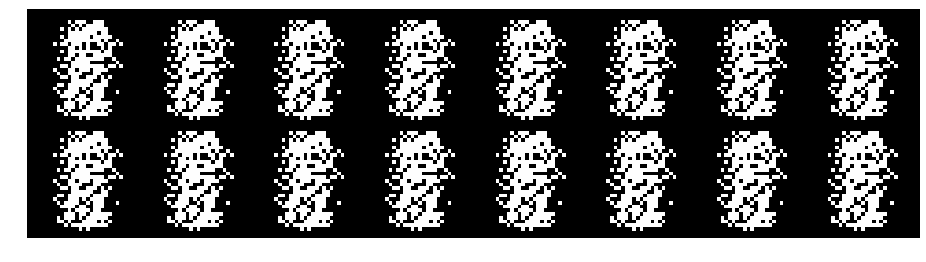

Epoch: [10/200], Batch Num: [300/600]
Discriminator Loss: 0.0000, Generator Loss: 19.4495
D(x): 1.0000, D(G(z)): 0.0000


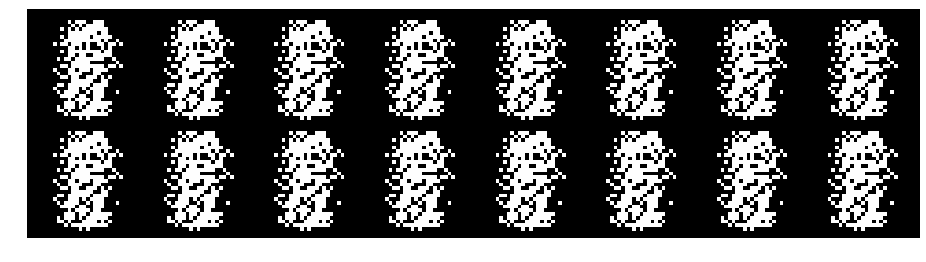

Epoch: [10/200], Batch Num: [400/600]
Discriminator Loss: 0.0000, Generator Loss: 19.7618
D(x): 1.0000, D(G(z)): 0.0000


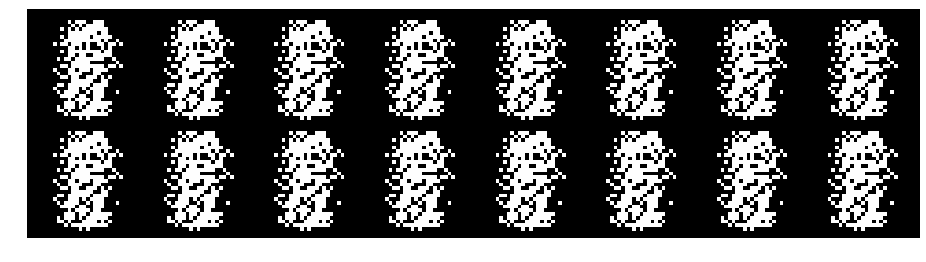

Epoch: [10/200], Batch Num: [500/600]
Discriminator Loss: 0.0000, Generator Loss: 20.4120
D(x): 1.0000, D(G(z)): 0.0000


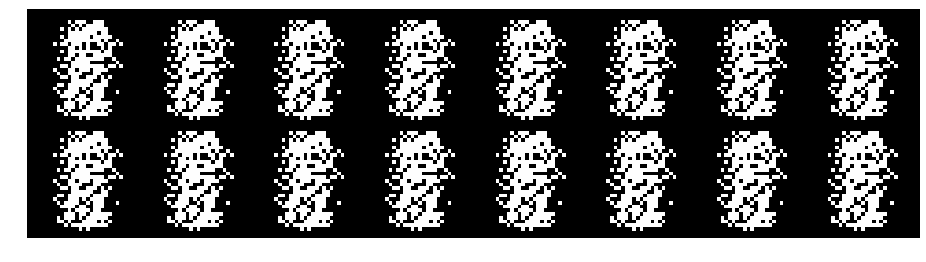

Epoch: [11/200], Batch Num: [0/600]
Discriminator Loss: 0.0000, Generator Loss: 20.7643
D(x): 1.0000, D(G(z)): 0.0000


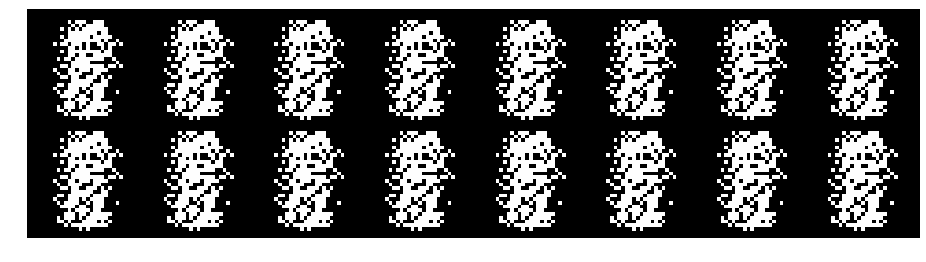

Epoch: [11/200], Batch Num: [100/600]
Discriminator Loss: 0.0000, Generator Loss: 20.5128
D(x): 1.0000, D(G(z)): 0.0000


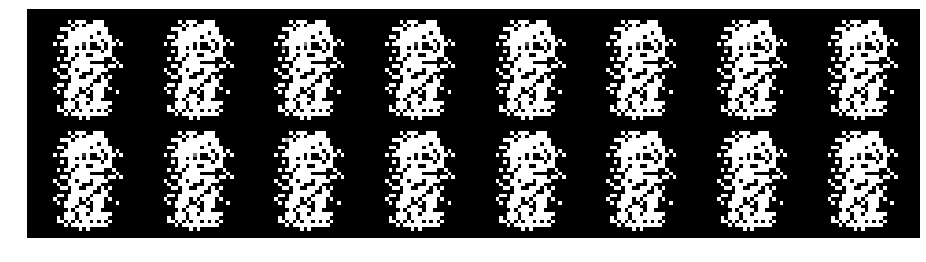

Epoch: [11/200], Batch Num: [200/600]
Discriminator Loss: 0.0000, Generator Loss: 17.3185
D(x): 1.0000, D(G(z)): 0.0000


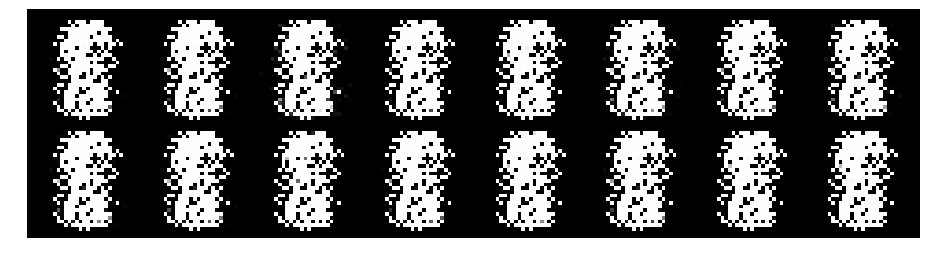

Epoch: [11/200], Batch Num: [300/600]
Discriminator Loss: 0.0000, Generator Loss: 51.3791
D(x): 1.0000, D(G(z)): 0.0000


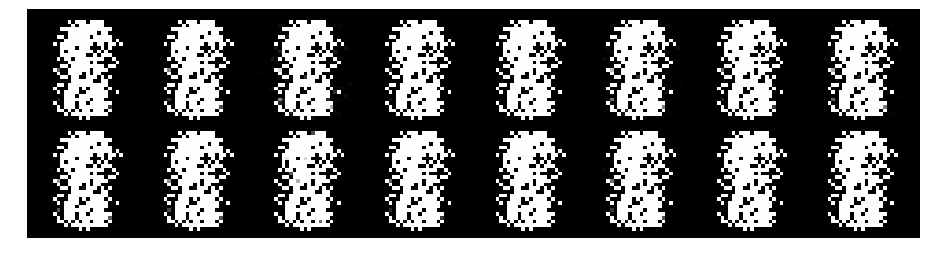

Epoch: [11/200], Batch Num: [400/600]
Discriminator Loss: 0.0000, Generator Loss: 50.1100
D(x): 1.0000, D(G(z)): 0.0000


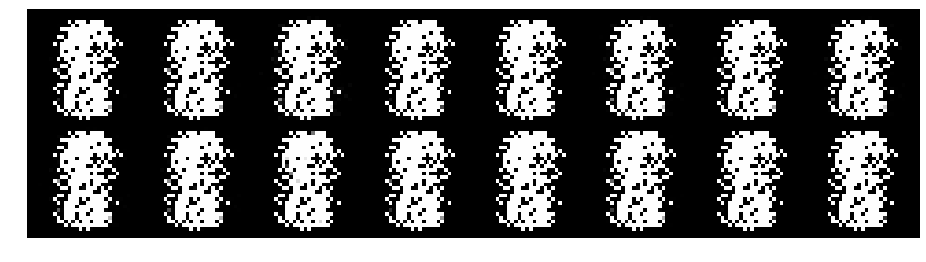

Epoch: [11/200], Batch Num: [500/600]
Discriminator Loss: 0.0000, Generator Loss: 50.7666
D(x): 1.0000, D(G(z)): 0.0000


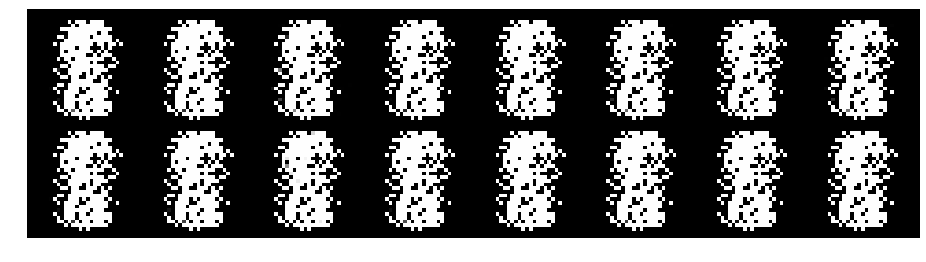

Epoch: [12/200], Batch Num: [0/600]
Discriminator Loss: 0.0000, Generator Loss: 49.8309
D(x): 1.0000, D(G(z)): 0.0000


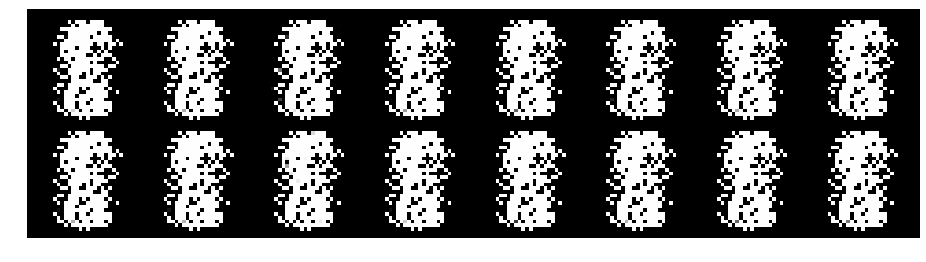

Epoch: [12/200], Batch Num: [100/600]
Discriminator Loss: 0.0000, Generator Loss: 49.2948
D(x): 1.0000, D(G(z)): 0.0000


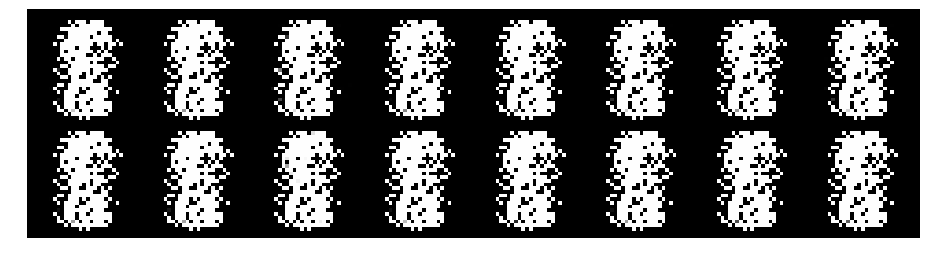

Epoch: [12/200], Batch Num: [200/600]
Discriminator Loss: 0.0000, Generator Loss: 47.5646
D(x): 1.0000, D(G(z)): 0.0000


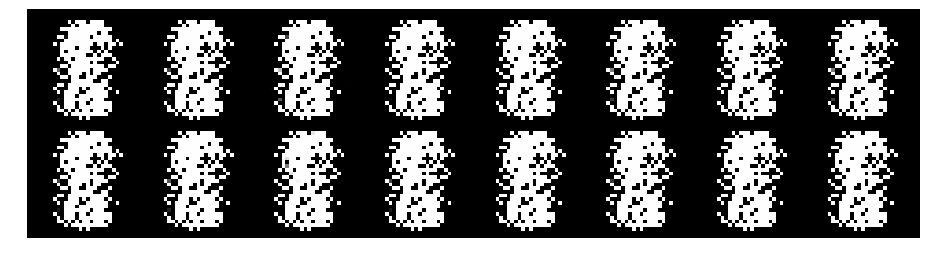

Epoch: [12/200], Batch Num: [300/600]
Discriminator Loss: 0.0000, Generator Loss: 48.6062
D(x): 1.0000, D(G(z)): 0.0000


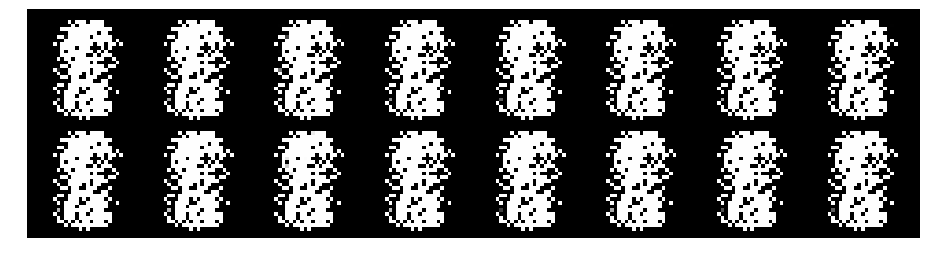

Epoch: [12/200], Batch Num: [400/600]
Discriminator Loss: 0.0000, Generator Loss: 48.8432
D(x): 1.0000, D(G(z)): 0.0000


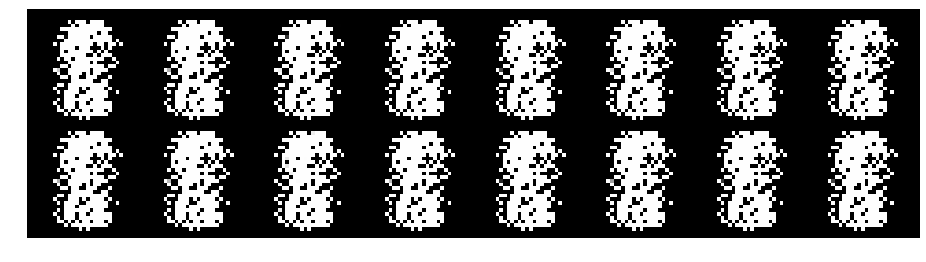

Epoch: [12/200], Batch Num: [500/600]
Discriminator Loss: 0.0000, Generator Loss: 47.4432
D(x): 1.0000, D(G(z)): 0.0000


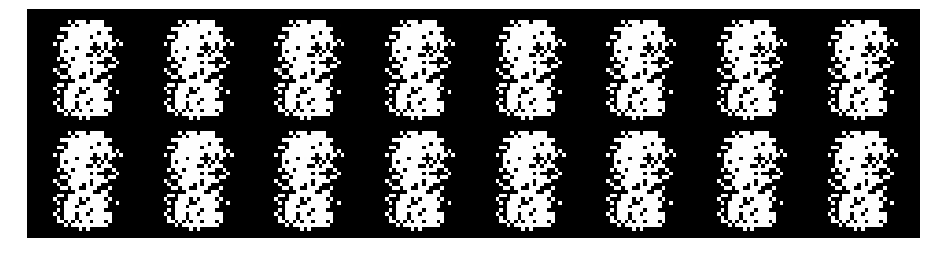

Epoch: [13/200], Batch Num: [0/600]
Discriminator Loss: 0.0000, Generator Loss: 47.5253
D(x): 1.0000, D(G(z)): 0.0000


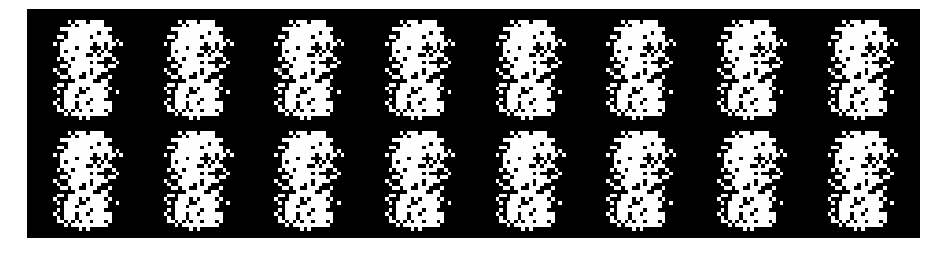

Epoch: [13/200], Batch Num: [100/600]
Discriminator Loss: 0.0000, Generator Loss: 46.5440
D(x): 1.0000, D(G(z)): 0.0000


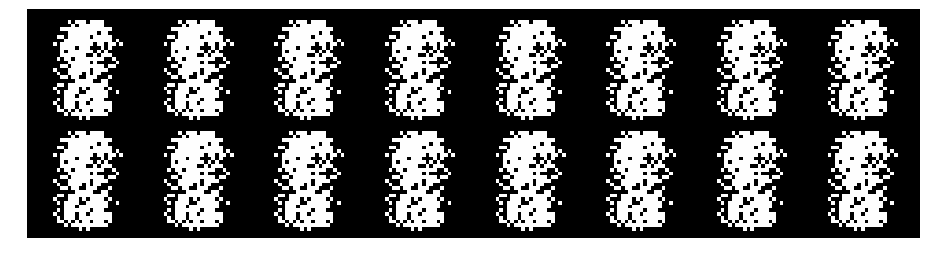

Epoch: [13/200], Batch Num: [200/600]
Discriminator Loss: 0.0000, Generator Loss: 47.3660
D(x): 1.0000, D(G(z)): 0.0000


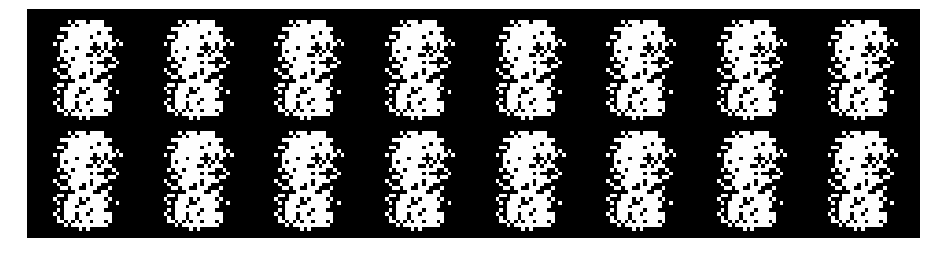

Epoch: [13/200], Batch Num: [300/600]
Discriminator Loss: 0.0000, Generator Loss: 47.3822
D(x): 1.0000, D(G(z)): 0.0000


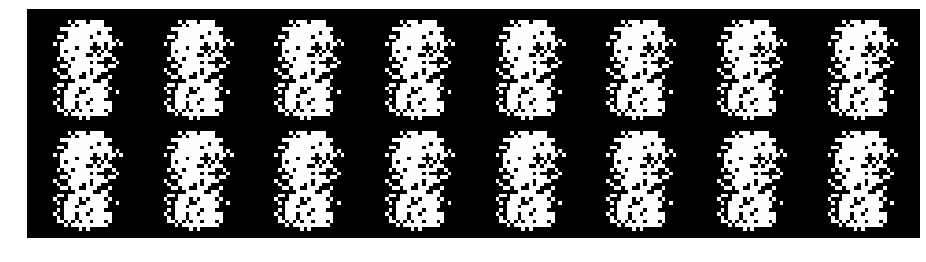

Epoch: [13/200], Batch Num: [400/600]
Discriminator Loss: 0.0000, Generator Loss: 46.6593
D(x): 1.0000, D(G(z)): 0.0000


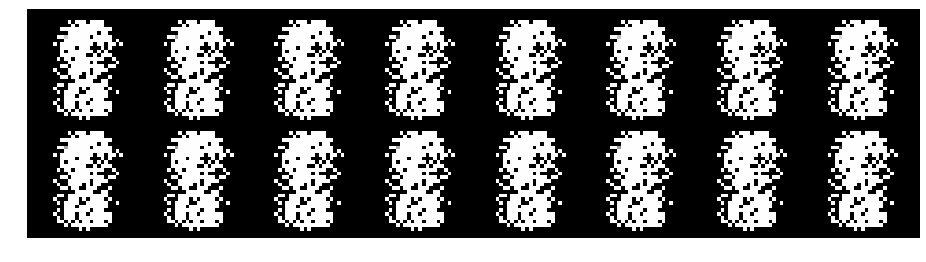

Epoch: [13/200], Batch Num: [500/600]
Discriminator Loss: 0.0000, Generator Loss: 46.4428
D(x): 1.0000, D(G(z)): 0.0000


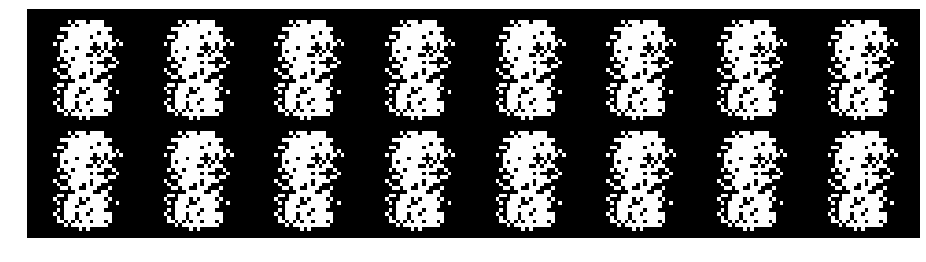

Epoch: [14/200], Batch Num: [0/600]
Discriminator Loss: 0.0000, Generator Loss: 45.8427
D(x): 1.0000, D(G(z)): 0.0000


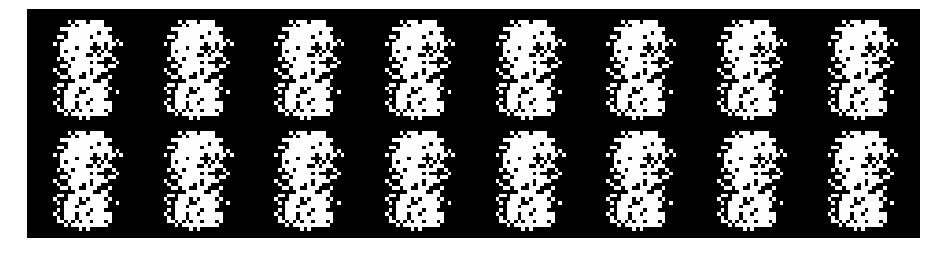

Epoch: [14/200], Batch Num: [100/600]
Discriminator Loss: 0.0000, Generator Loss: 46.7234
D(x): 1.0000, D(G(z)): 0.0000


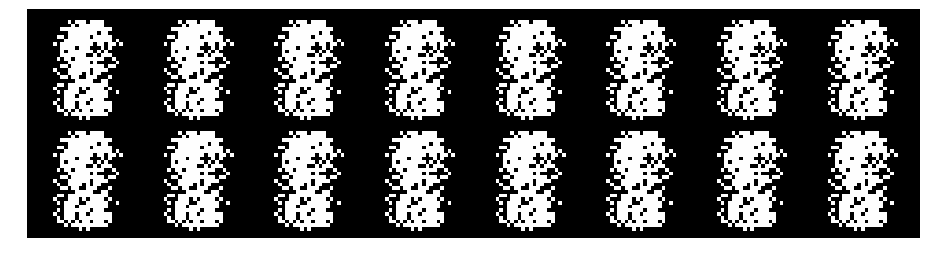

Epoch: [14/200], Batch Num: [200/600]
Discriminator Loss: 0.0000, Generator Loss: 45.6534
D(x): 1.0000, D(G(z)): 0.0000


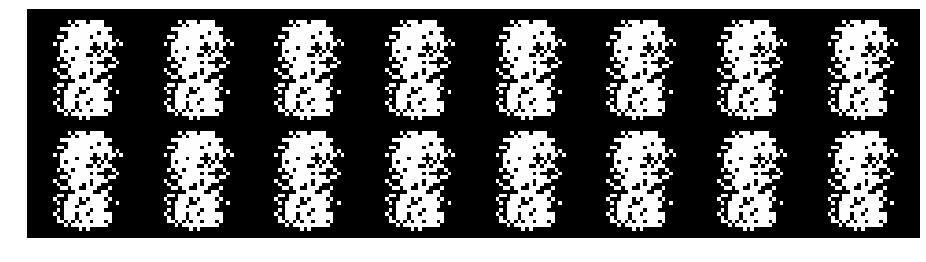

Epoch: [14/200], Batch Num: [300/600]
Discriminator Loss: 0.0000, Generator Loss: 46.4584
D(x): 1.0000, D(G(z)): 0.0000


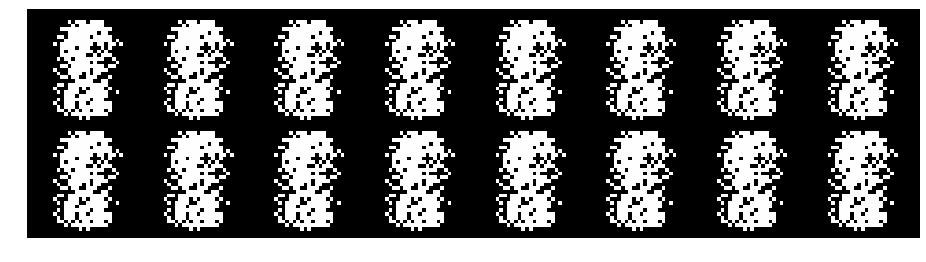

Epoch: [14/200], Batch Num: [400/600]
Discriminator Loss: 0.0000, Generator Loss: 46.4684
D(x): 1.0000, D(G(z)): 0.0000


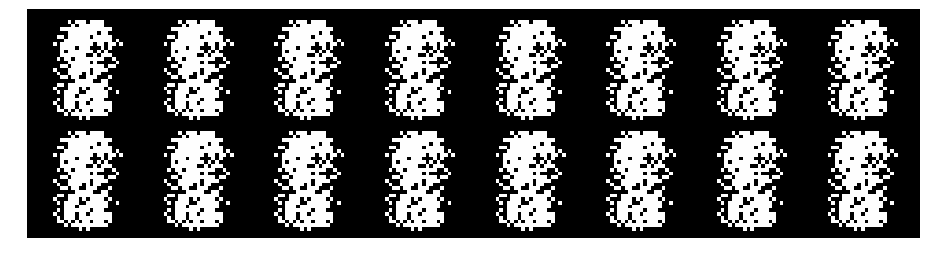

Epoch: [14/200], Batch Num: [500/600]
Discriminator Loss: 0.0000, Generator Loss: 46.5012
D(x): 1.0000, D(G(z)): 0.0000


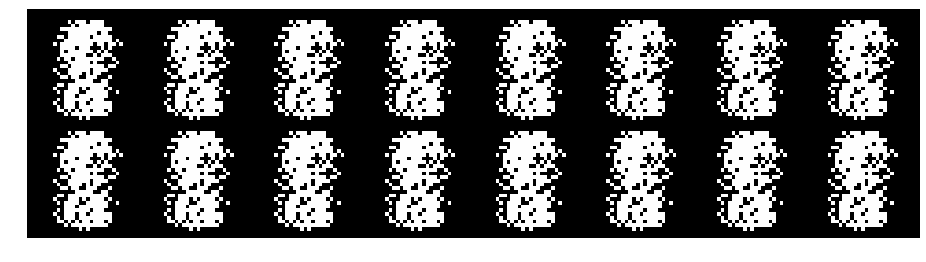

Epoch: [15/200], Batch Num: [0/600]
Discriminator Loss: 0.0000, Generator Loss: 45.4030
D(x): 1.0000, D(G(z)): 0.0000


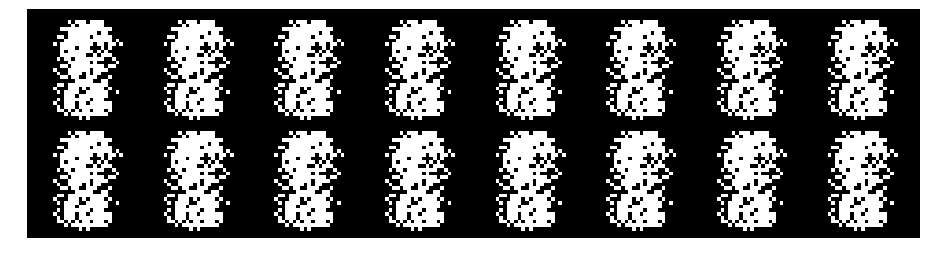

Epoch: [15/200], Batch Num: [100/600]
Discriminator Loss: 0.0000, Generator Loss: 46.1524
D(x): 1.0000, D(G(z)): 0.0000


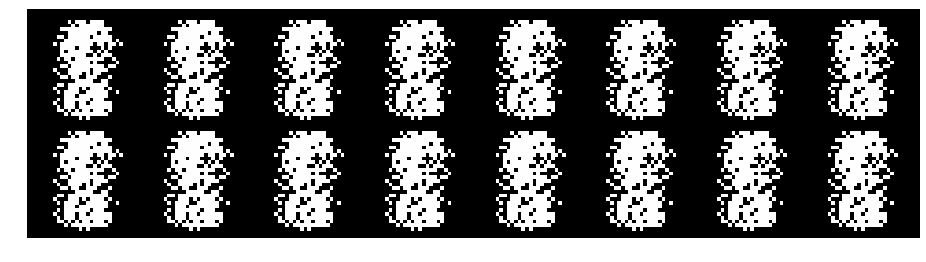

Epoch: [15/200], Batch Num: [200/600]
Discriminator Loss: 0.0000, Generator Loss: 46.2619
D(x): 1.0000, D(G(z)): 0.0000


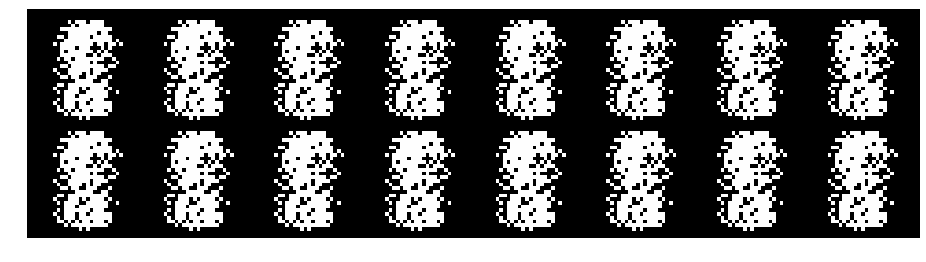

Epoch: [15/200], Batch Num: [300/600]
Discriminator Loss: 0.0000, Generator Loss: 44.9861
D(x): 1.0000, D(G(z)): 0.0000


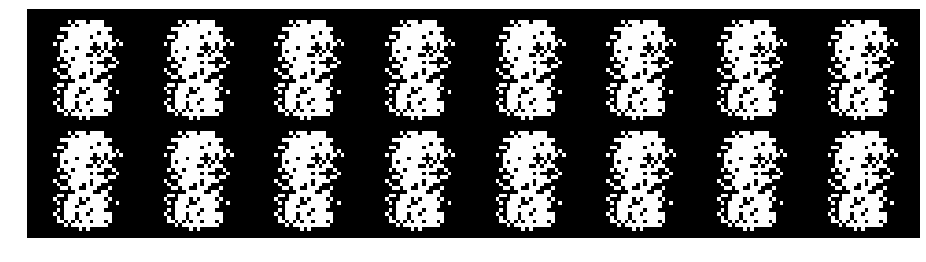

Epoch: [15/200], Batch Num: [400/600]
Discriminator Loss: 0.0000, Generator Loss: 45.2569
D(x): 1.0000, D(G(z)): 0.0000


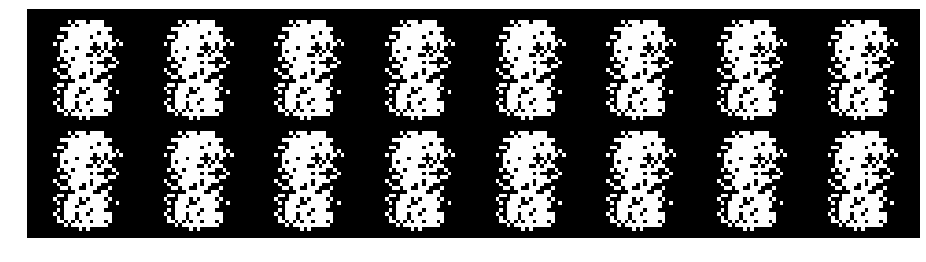

Epoch: [15/200], Batch Num: [500/600]
Discriminator Loss: 0.0000, Generator Loss: 44.8123
D(x): 1.0000, D(G(z)): 0.0000


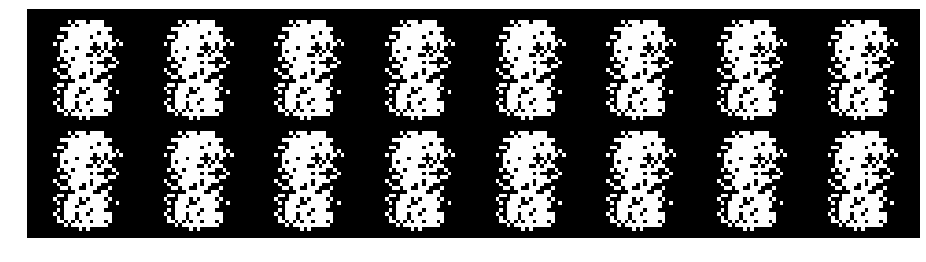

Epoch: [16/200], Batch Num: [0/600]
Discriminator Loss: 0.0000, Generator Loss: 45.1472
D(x): 1.0000, D(G(z)): 0.0000


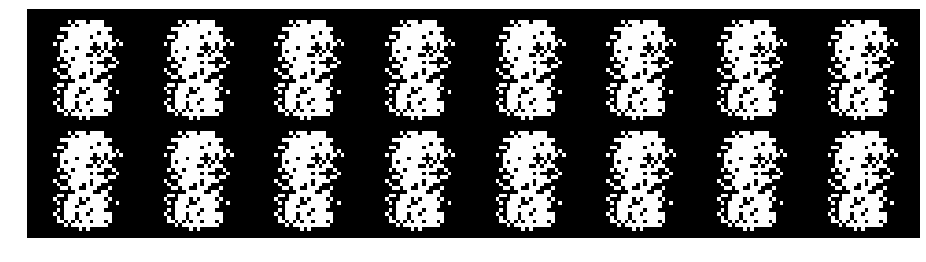

Epoch: [16/200], Batch Num: [100/600]
Discriminator Loss: 0.0000, Generator Loss: 45.4012
D(x): 1.0000, D(G(z)): 0.0000


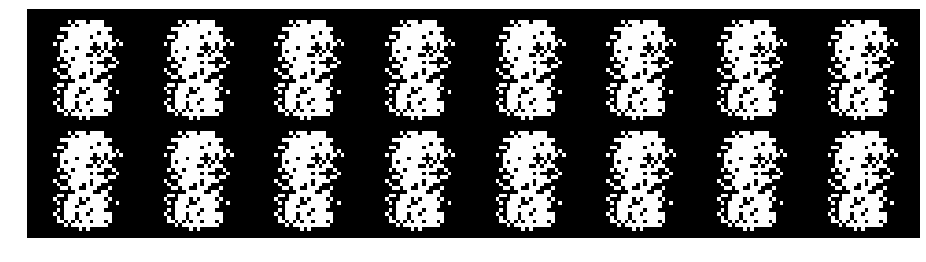

Epoch: [16/200], Batch Num: [200/600]
Discriminator Loss: 0.0000, Generator Loss: 45.6180
D(x): 1.0000, D(G(z)): 0.0000


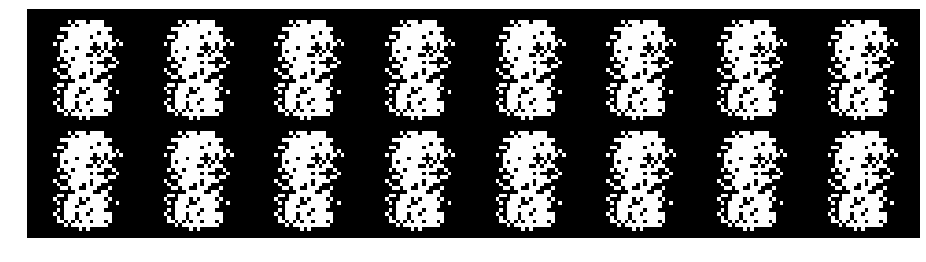

Epoch: [16/200], Batch Num: [300/600]
Discriminator Loss: 0.0000, Generator Loss: 44.3486
D(x): 1.0000, D(G(z)): 0.0000


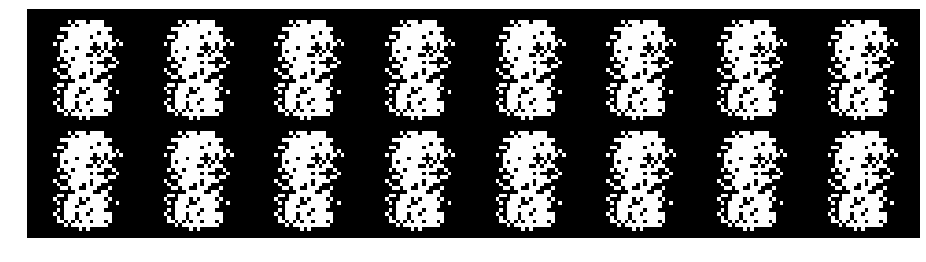

Epoch: [16/200], Batch Num: [400/600]
Discriminator Loss: 0.0000, Generator Loss: 43.7842
D(x): 1.0000, D(G(z)): 0.0000


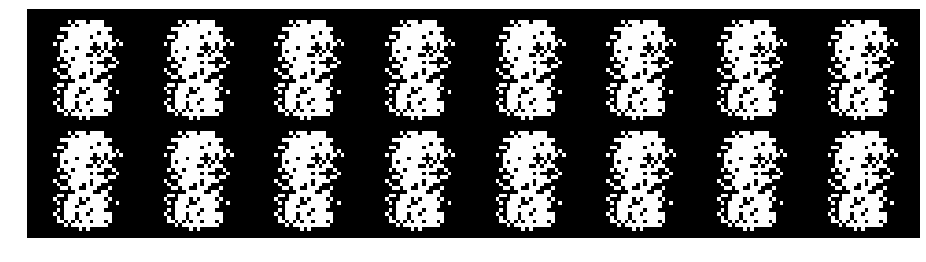

Epoch: [16/200], Batch Num: [500/600]
Discriminator Loss: 0.0000, Generator Loss: 43.3475
D(x): 1.0000, D(G(z)): 0.0000


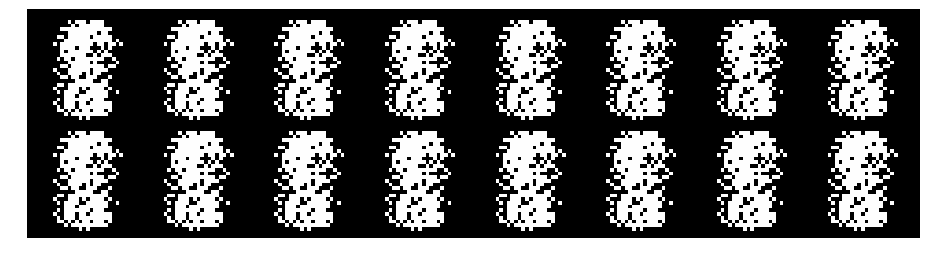

Epoch: [17/200], Batch Num: [0/600]
Discriminator Loss: 0.0000, Generator Loss: 45.4960
D(x): 1.0000, D(G(z)): 0.0000


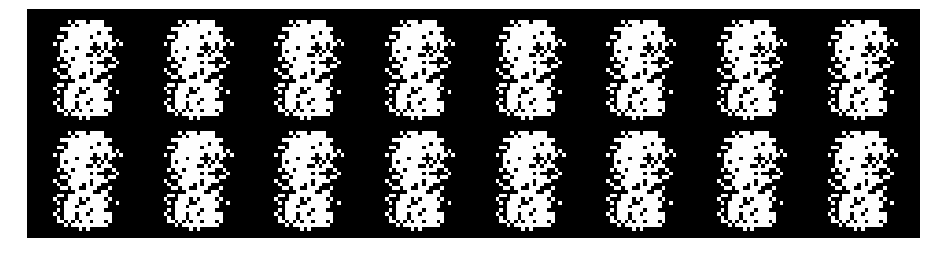

Epoch: [17/200], Batch Num: [100/600]
Discriminator Loss: 0.0000, Generator Loss: 44.4452
D(x): 1.0000, D(G(z)): 0.0000


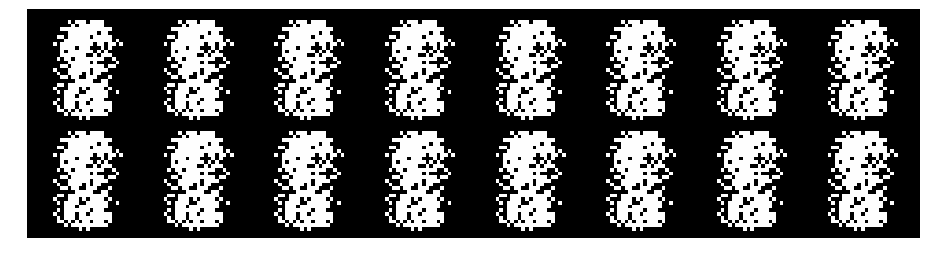

Epoch: [17/200], Batch Num: [200/600]
Discriminator Loss: 0.0000, Generator Loss: 44.3935
D(x): 1.0000, D(G(z)): 0.0000


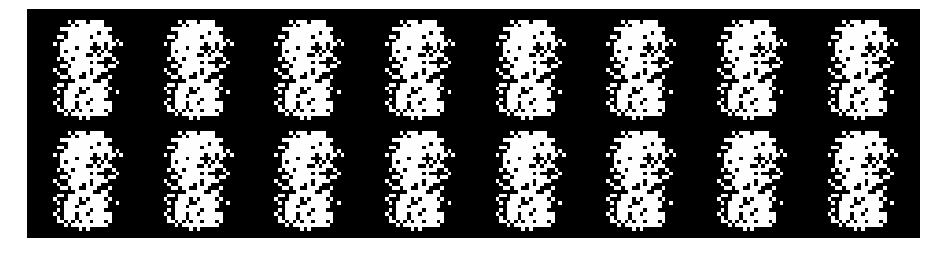

Epoch: [17/200], Batch Num: [300/600]
Discriminator Loss: 0.0000, Generator Loss: 44.6995
D(x): 1.0000, D(G(z)): 0.0000


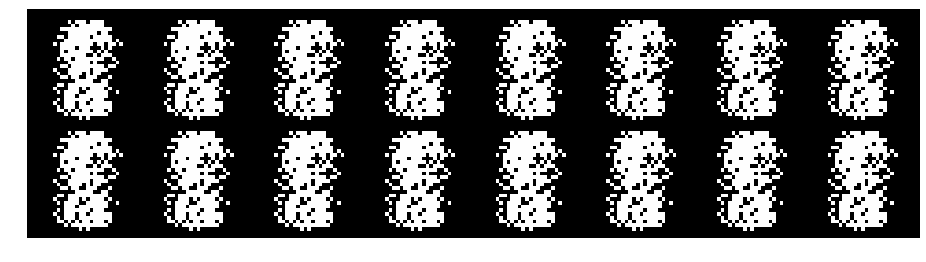

Epoch: [17/200], Batch Num: [400/600]
Discriminator Loss: 0.0000, Generator Loss: 44.2826
D(x): 1.0000, D(G(z)): 0.0000


In [0]:
num_epochs = 200
for epoch in range(num_epochs):
    for n_batch, (real_batch,_) in enumerate(data_loader):
        N = real_batch.size(0)
        # 1. Train Discriminator
        real_data = Variable(images_to_vectors(real_batch))
        # Generate fake data and detach 
        # (so gradients are not calculated for generator)
        fake_data = generator(noise(N)).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = \
              train_discriminator(d_optimizer, real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(N))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Log batch error
        logger.log(d_error, g_error, epoch, n_batch, num_batches)
        # Display Progress every few batches
        if (n_batch) % 100 == 0: 
            test_images = vectors_to_images(generator(test_noise))
            test_images = test_images.data
            logger.log_images(
                test_images, num_test_samples, 
                epoch, n_batch, num_batches
            );
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )